# CUSTOMER CHURN ANALYSIS 
* [Jin Kwon](https://www.linkedin.com/in/jinkwon/)
* Last updated: 11-04-2020 (PST)

---
**Goal:**  
End to end analysis on Telco customer churn data main focus being: 
* Identify what features contribute to customer churn.  
* Magnitude of each feature's contribution and uncertainties associated. 
* Business conclusion that we can share with Telco.  


I added references at the end of the notebook that all composed the bits and pieces of this notebook. Please go check them out. 

---

In [2]:
library(tidyverse) # imports ggplot2, dplyr, tidyr, readr, purrr, tibble, stringr, and forcats

# Normality Test
library(car) # for qqplot
library(nortest) # Anderson-Darling normality test

# Correspondence Analysis 
library(FactoMineR)
library(factoextra)

# time-to-event (survival) analysis packages
library(KMsurv)
library(survival)
library(survminer)

# correlation 
library(corrr)

# contingency table
library(MASS)


# plotting 
library(gridExtra) # grid.arrange

# library(glmnet)
# library(factoextra)
# library(ggfortify)
# library(devtools)
# # library(ggbiplot)
# library(factoextra)
# library(MASS)
# library(cluster)
# library(gridExtra)
# library(party)


# set the max number of columns displayed in Jupyter Notebook without truncation
options(repr.matrix.max.cols=30, repr.matrix.max.rows=100)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: ggpubr


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [3]:
# load data 
telco_df <- read.csv("../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

---
## <font color = 'crimson'> 1. Initial Data Quality Check </font>

* Are the `customerID`s unique? Check if is there only one row (data point) per `customerID`? 
* Any NAs? 

### <font color = 'darkslateblue'> 1.1. Is the customerID unique? That is, is there only one row per customerID? </font>

In [4]:
row_count = nrow(telco_df)
uniqueID_count =length(unique(telco_df$customerID))
print(paste0("Number of Rows : ", row_count))
print(paste0("Number of Unique CustomerID : ", uniqueID_count))

if (row_count == uniqueID_count) {
    print("Customer ID is unique; ther is one data point per Customer ID.")
} else {
    print("Customer ID is not unique.")
}

[1] "Number of Rows : 7043"
[1] "Number of Unique CustomerID : 7043"
[1] "Customer ID is unique; ther is one data point per Customer ID."


**OBSERVATIONS:**
* There is only one row per Customer ID. Each Customer ID is unique!

### <font color = 'darkslateblue'> 1.2. Any NAs? </font>

In [5]:
summary(telco_df)

      customerID      gender     SeniorCitizen    Partner    Dependents
 0002-ORFBO:   1   Female:3488   Min.   :0.0000   No :3641   No :4933  
 0003-MKNFE:   1   Male  :3555   1st Qu.:0.0000   Yes:3402   Yes:2110  
 0004-TLHLJ:   1                 Median :0.0000                        
 0011-IGKFF:   1                 Mean   :0.1621                        
 0013-EXCHZ:   1                 3rd Qu.:0.0000                        
 0013-MHZWF:   1                 Max.   :1.0000                        
 (Other)   :7037                                                       
     tenure      PhoneService          MultipleLines     InternetService
 Min.   : 0.00   No : 682     No              :3390   DSL        :2421  
 1st Qu.: 9.00   Yes:6361     No phone service: 682   Fiber optic:3096  
 Median :29.00                Yes             :2971   No         :1526  
 Mean   :32.37                                                          
 3rd Qu.:55.00                                             

**OBSERVATIONS:**
* No N/As in all columns!

---

## <font color = 'crimson'> 2. Data Exploration </font>

Let's start with the simpler observations and move onto the ones that require a bit more efforts (e.g., data distribution, correlation). 

### <font color = 'darkslateblue'> 2.1. Univariate Data Exploration </font>

#### 2.1.1. Numerical Variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 11 rows containing non-finite values (stat_bin).”


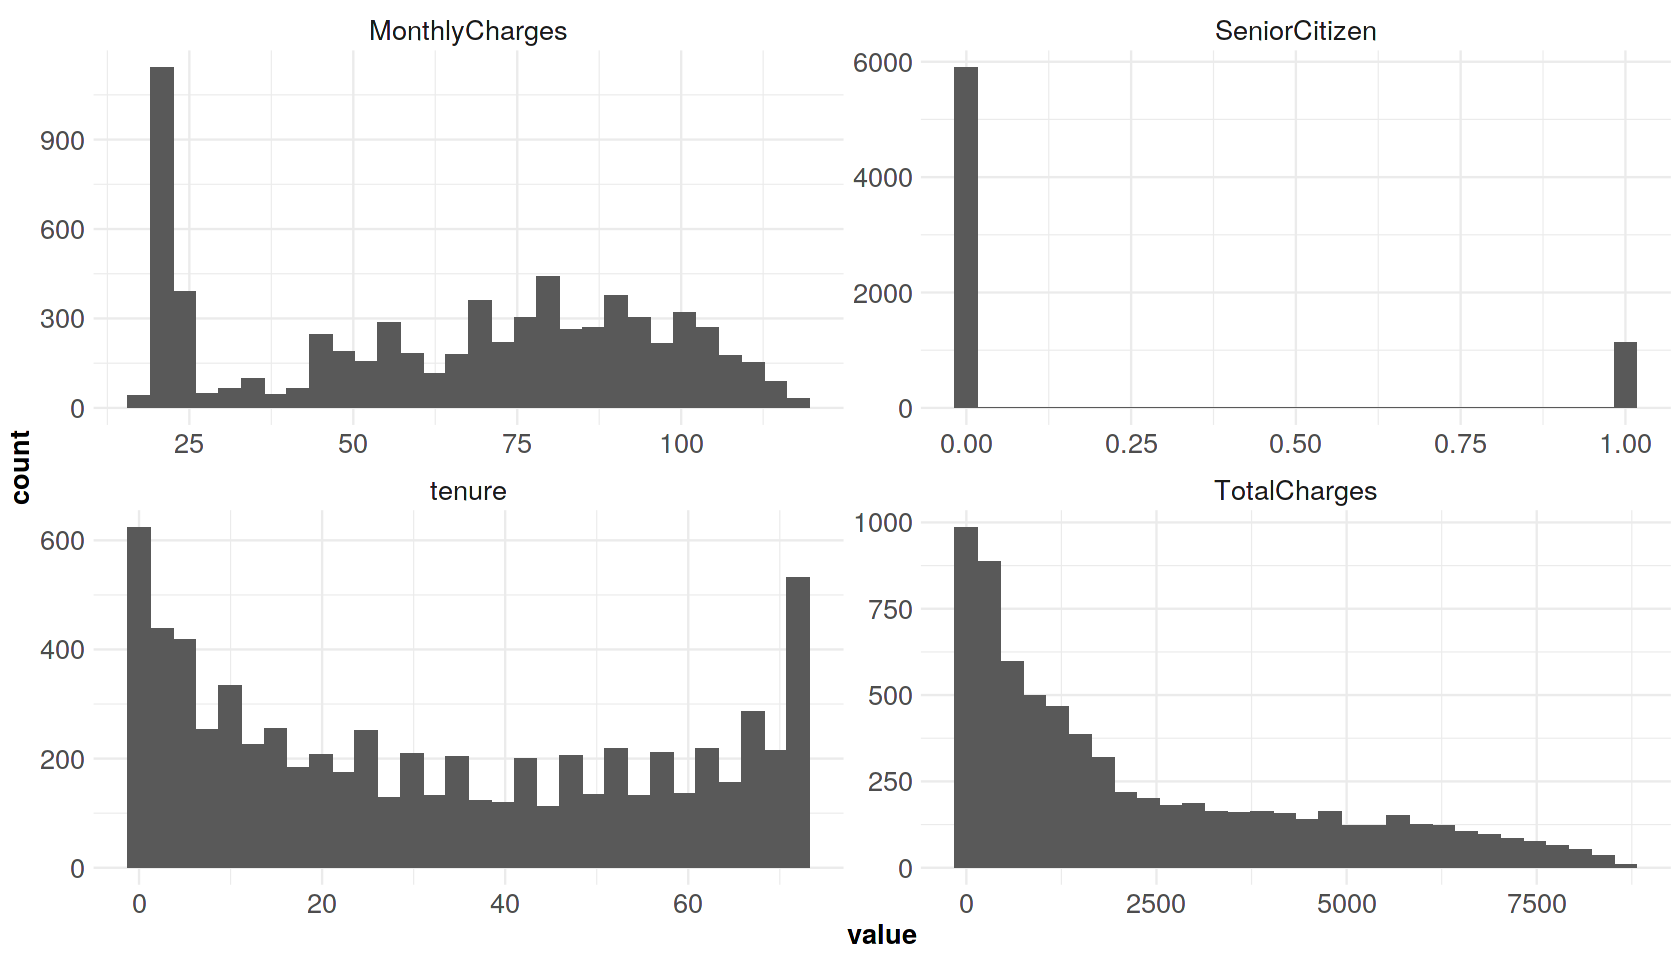

In [6]:
options(repr.plot.width = 14, repr.plot.height = 8)

# check out distribution of numeric feature(s) 
telco_df %>%
  keep(is.numeric) %>% 
  gather() %>% 
  ggplot(aes(value)) + theme_minimal() +
    facet_wrap(~ key, scales = "free") +
    geom_histogram() + 
    theme(axis.title=element_text(size=16,face="bold")) + 
    theme(text = element_text(size = 20))  

In [7]:
# more on tenure distribution (Number of Months)
min(telco_df$tenure)
max(telco_df$tenure)
sprintf('Max tenure is %i years.', max(telco_df$tenure)/12)

[1] 0

[1] 72

[1] "Max tenure is 6 years."

**OBSERVATIONS:**
* Again, we see that the values of `SeniorCitizen` is using numeric 0 and 1 as binary label for True and False, respectively. 
* `MonthlyCharges` column has a high concentration around 20, and the rest the values are somewhat a normal distribution with skew to the left.
* `TotalCharges` column seem to follow an exponential distribution. 

#### 2.1.2. Categorical Variables
ref: https://stackoverflow.com/questions/38184288/how-to-plot-multiple-factor-columns-with-ggplot

In [8]:
colnames(telco_df)

[1] "customerID"       "gender"           "SeniorCitizen"    "Partner"         
 [5] "Dependents"       "tenure"           "PhoneService"     "MultipleLines"   
 [9] "InternetService"  "OnlineSecurity"   "OnlineBackup"     "DeviceProtection"
[13] "TechSupport"      "StreamingTV"      "StreamingMovies"  "Contract"        
[17] "PaperlessBilling" "PaymentMethod"    "MonthlyCharges"   "TotalCharges"    
[21] "Churn"

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


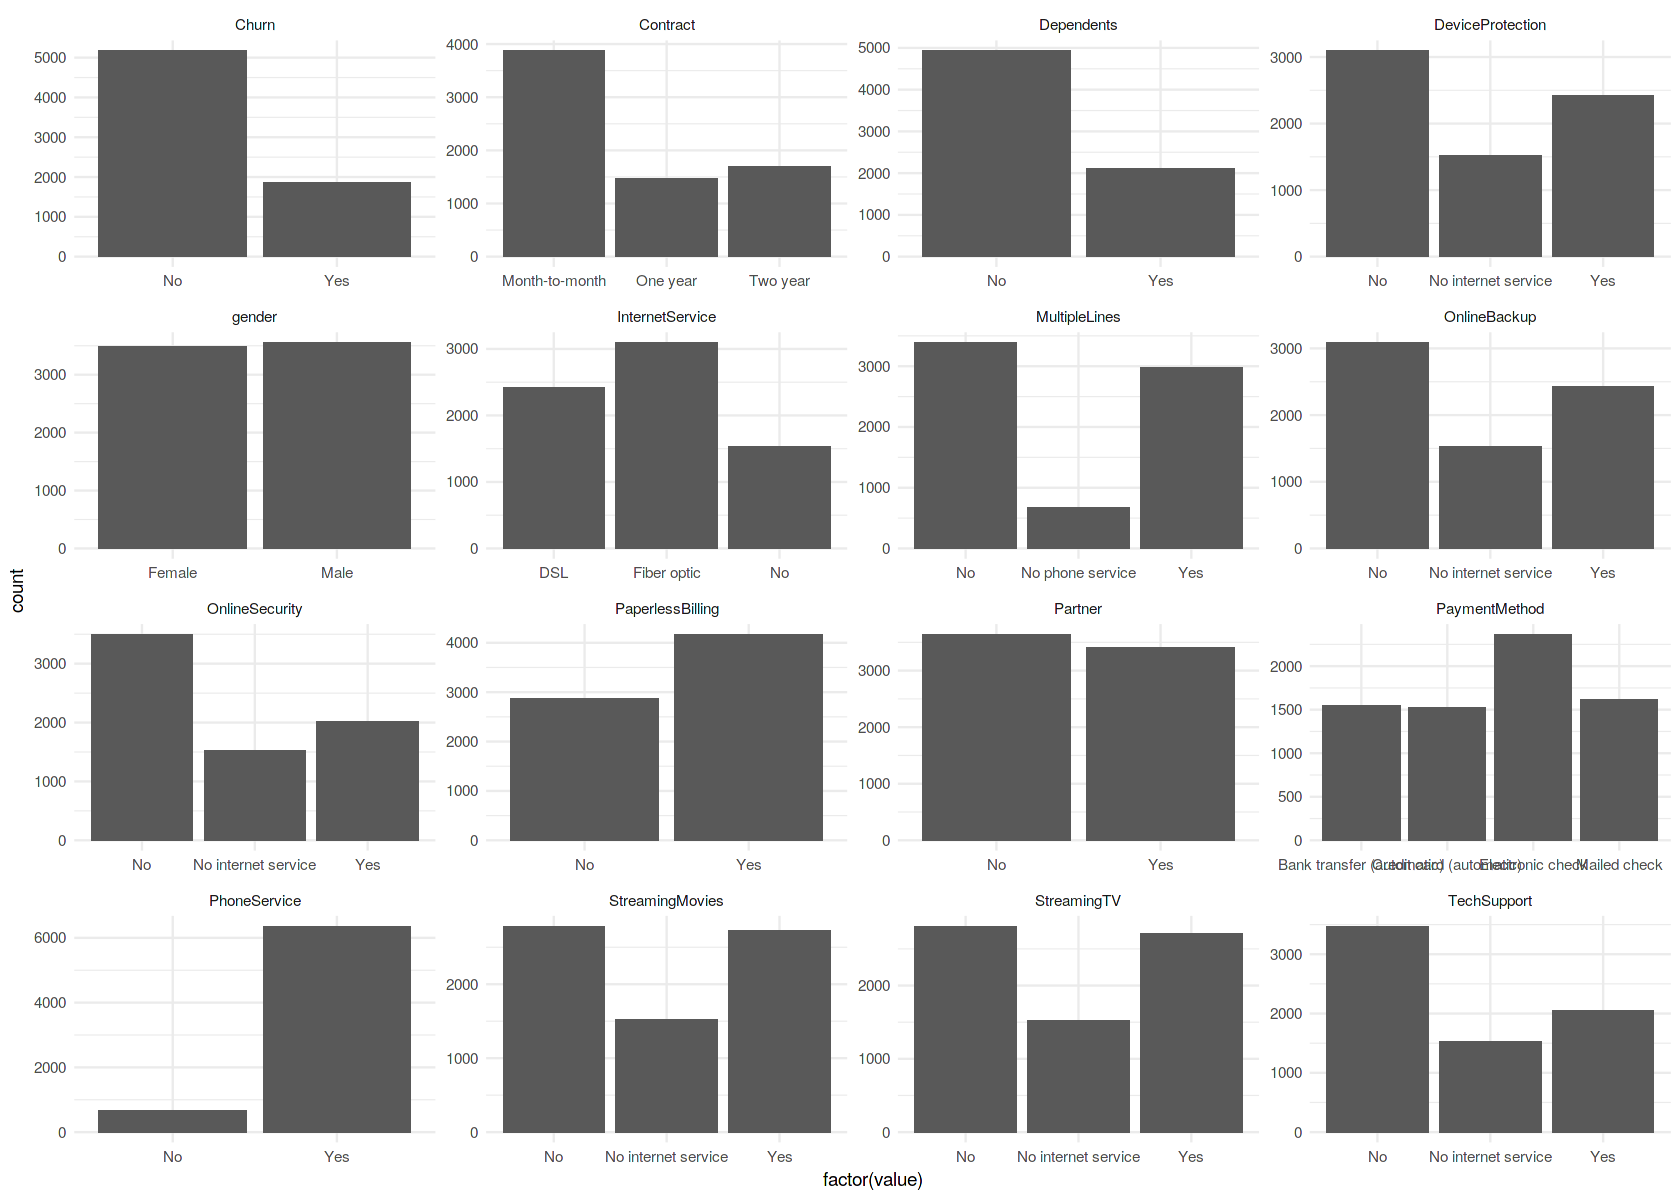

In [9]:
options(repr.plot.width = 14, repr.plot.height = 10)

telco_df %>%
    dplyr::select(-c('customerID')) %>%
    keep(is.factor) %>% 
    gather() %>% 
    ggplot(aes(x = factor(value)))+ 
    theme(axis.text.x = element_text(face = "bold", size = 8, angle = 90)) +
    facet_wrap(~ key, scales = "free") +
    geom_bar() + theme_minimal()

**OBSERVATIONS:**
* We have a unique key (`customerID`), 16 categorical columns, and 4 numerical columns. 
    * `SeniorCitizen`, one of the numerical columns, uses 1 and 0 as a binary label (wonder it is not in True/False like many other binary categorical columns). 
    * 5 columns are only composef of Yes or No. 
    * 6 columns have Yes, No, and `No internet service` option. 
    * 1 column, `MultipleLines`, has Yes, No, and `No phone service` option.
* The relaitonships of "Yes/No + third option" columns can be visualized like the following: 

| `PhoneService` | `MultipleLines` | 
| --- | --- |
|No | No phone service 
| Yes | Yes | 
| Yes | No | 

| `InteretService` | `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovie` | 
| --- | --- |
|No | No internet service 
| Yes | Yes | 
| Yes | No | 


The column values on the right are dependent on the column values on the left, thus 7 columns alone can explain the 2 columns on the left. 

---
### <font color = 'darkslateblue'> 2.2. `MonthlyCharges` distributions separated by categorical features. </font>

* We saw above that the `MonthlyCharges` seem to be composed of multiple distributions (maybe of a narrow tall normal distribution with mean ~20 + a shallow wide normal distribution with mean ~ 90)
* In secion 1.2., we saw that we have categorical features `InternetService` and `PhoneService` which could determine the distribution of the `MonthlyCharges`. So that is what we will be seeing here.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



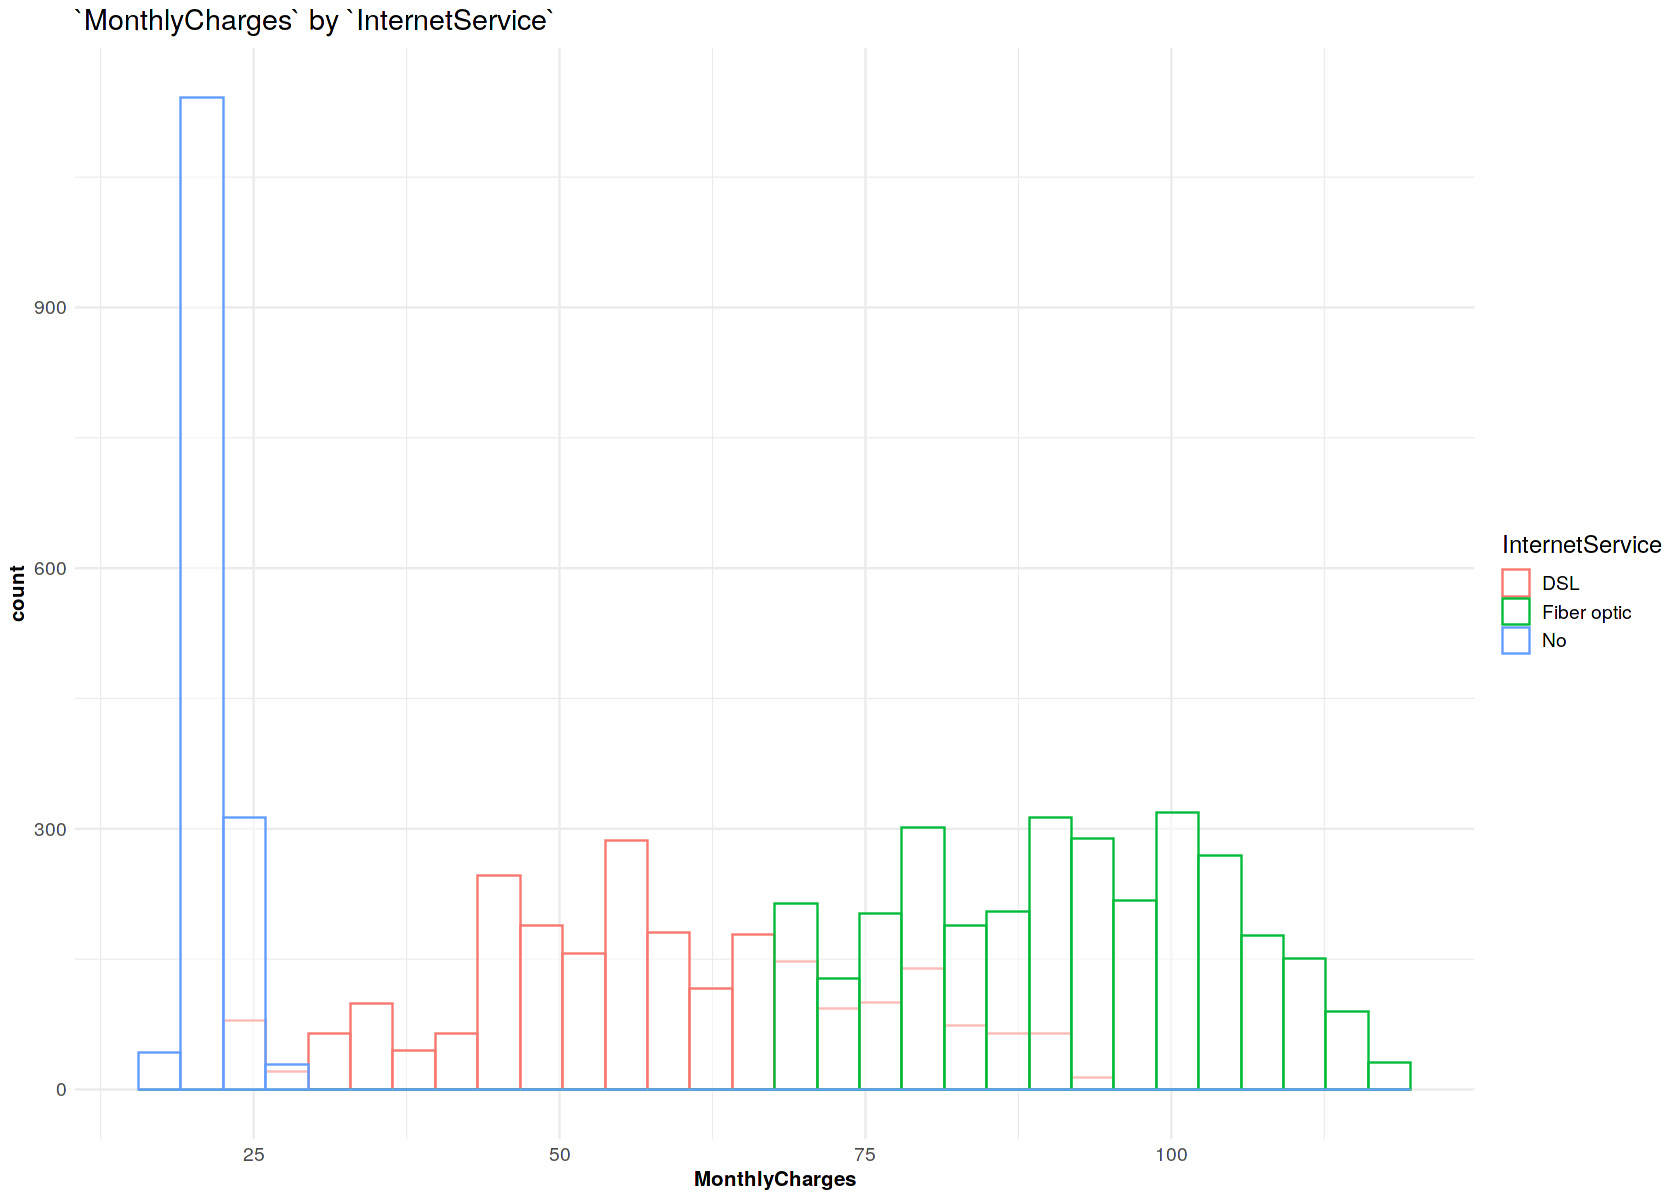

In [10]:
ggplot(telco_df, aes(x=MonthlyCharges, color=InternetService)) +
  geom_histogram(fill="white", alpha=0.5, position="identity") + theme_minimal() + 
    ggtitle("`MonthlyCharges` by `InternetService`") + 
    theme(axis.title=element_text(size=12,face="bold")) + 
    theme(text = element_text(size = 14)) +
    labs(color="InternetService")

**OBSERVATIONS:**

* There is only one row per Customer ID. Each Customer ID is unique!
* Customers' `MonthlyCharges` could be highly determined by the type of `InternetService`s. Fiber optics with average ~90, DSL ~60, and no service ~20. 
* Multiple sources validated that fiber optic services are faster than DSL and are do cost more https://www.highspeedinternet.com/resources/dsl-vs-fiber

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



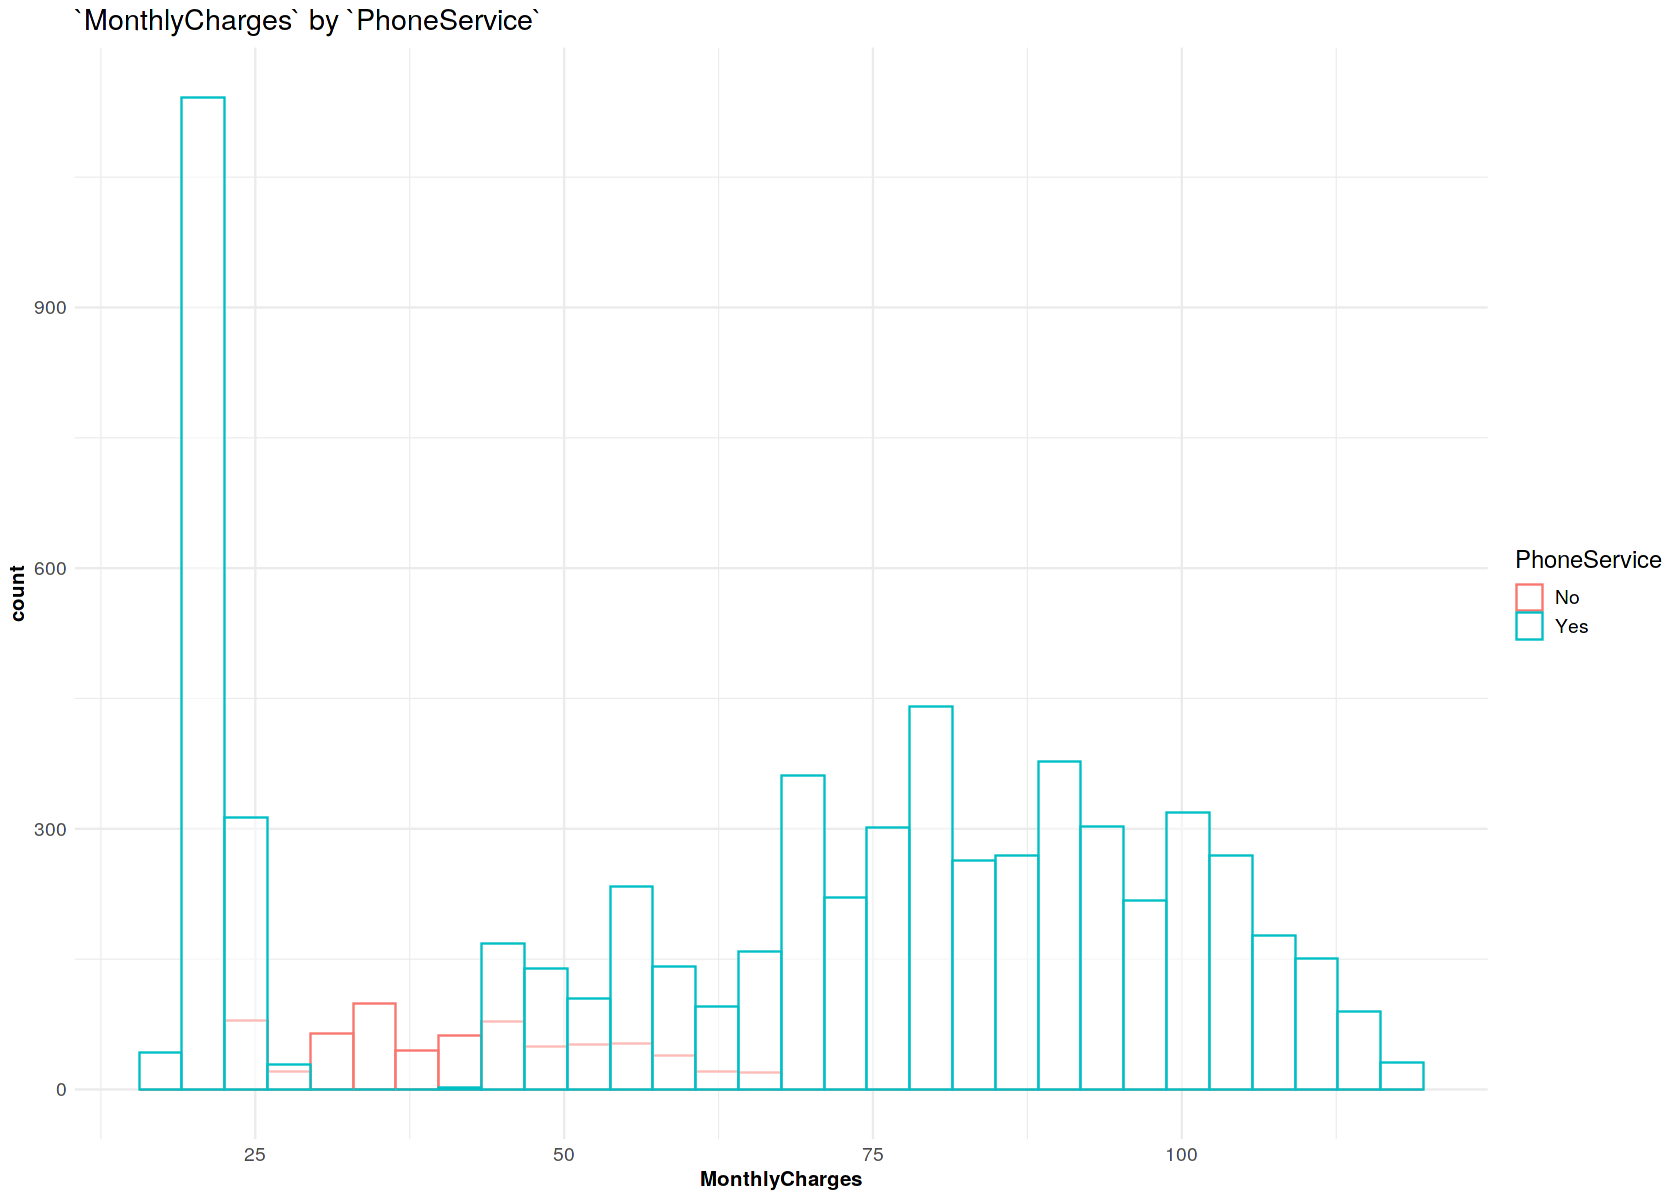

In [11]:
ggplot(telco_df, aes(x=MonthlyCharges, color=PhoneService)) +
  geom_histogram(fill="white", alpha=0.5, position="identity") + theme_minimal() + 
    ggtitle("`MonthlyCharges` by `PhoneService`") + 
    theme(axis.title=element_text(size=12,face="bold")) + 
    theme(text = element_text(size = 14)) +
    labs(color="PhoneService")

**OBSERVATIONS:**

* There is only one row per Customer ID. Each Customer ID is unique!
* Comparing with "`MonthlyCharges` by `InternetService`" plot, we see there is no overlap between the customers without (`No`) PhoneService and fiber optics internet service. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



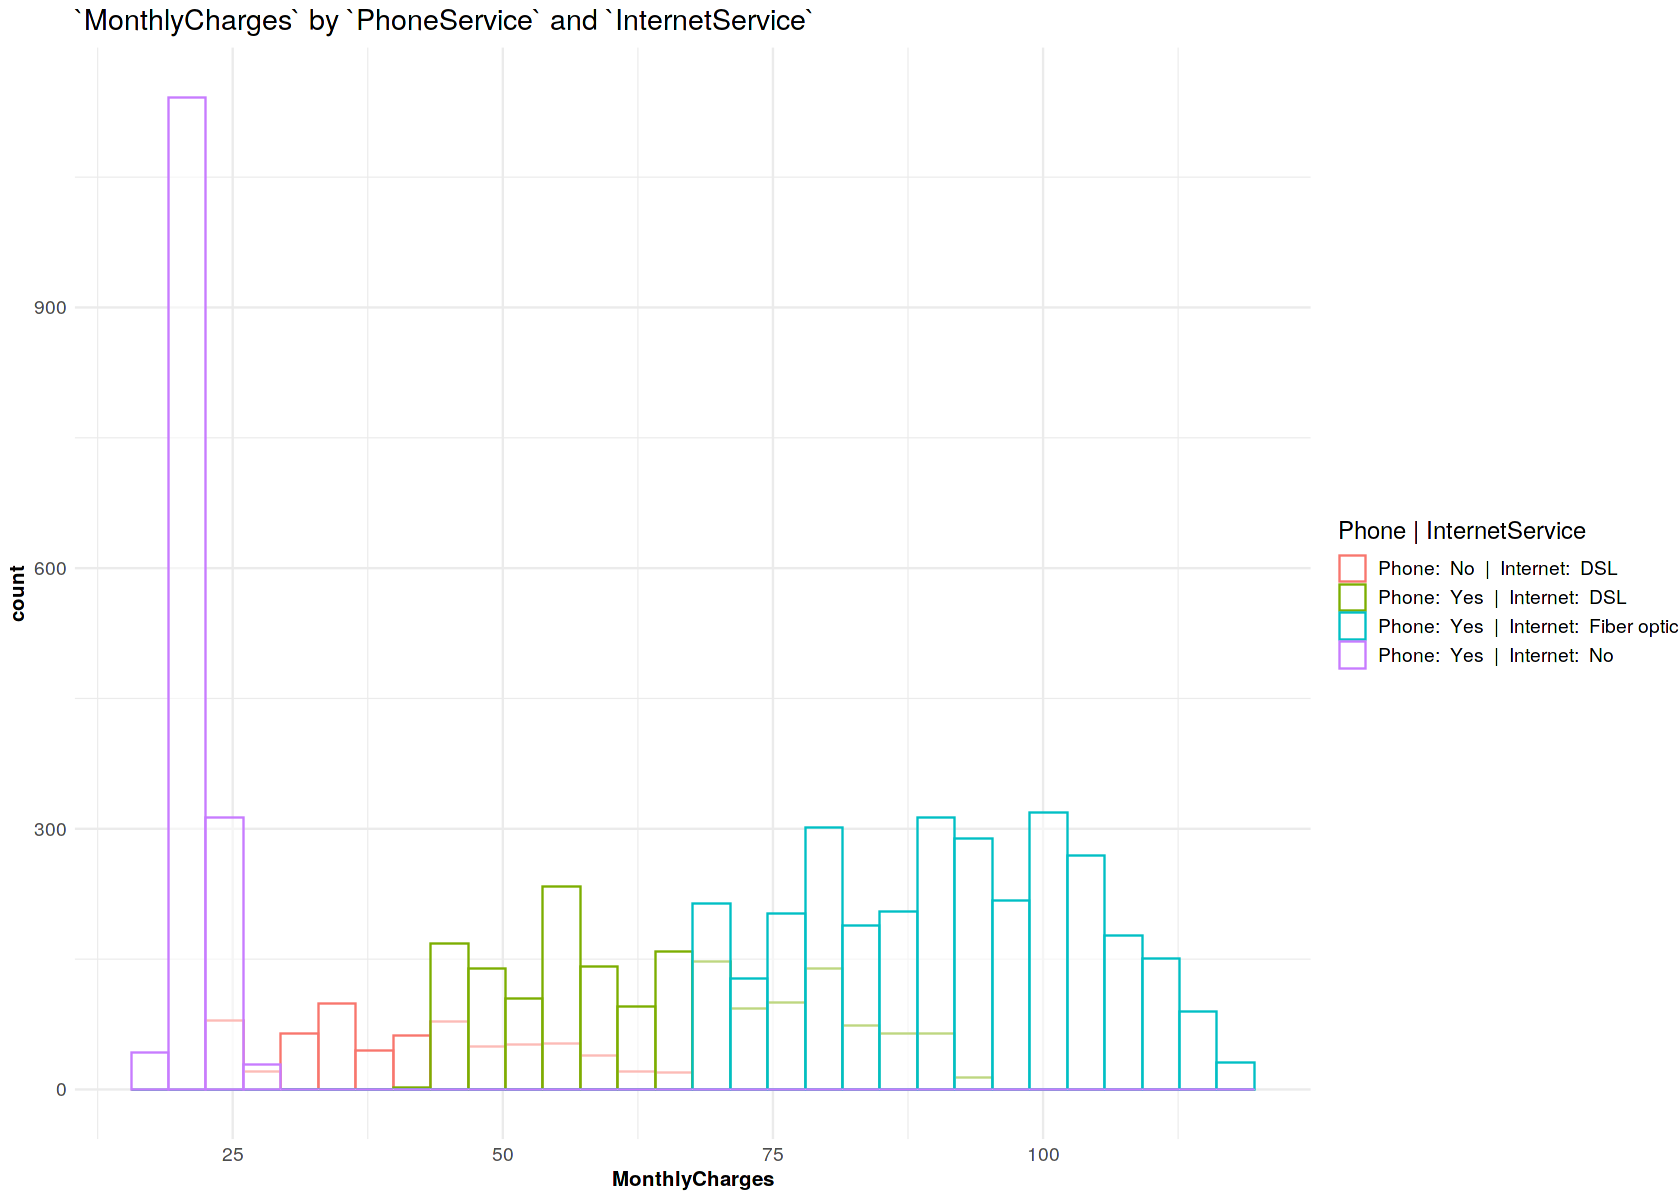

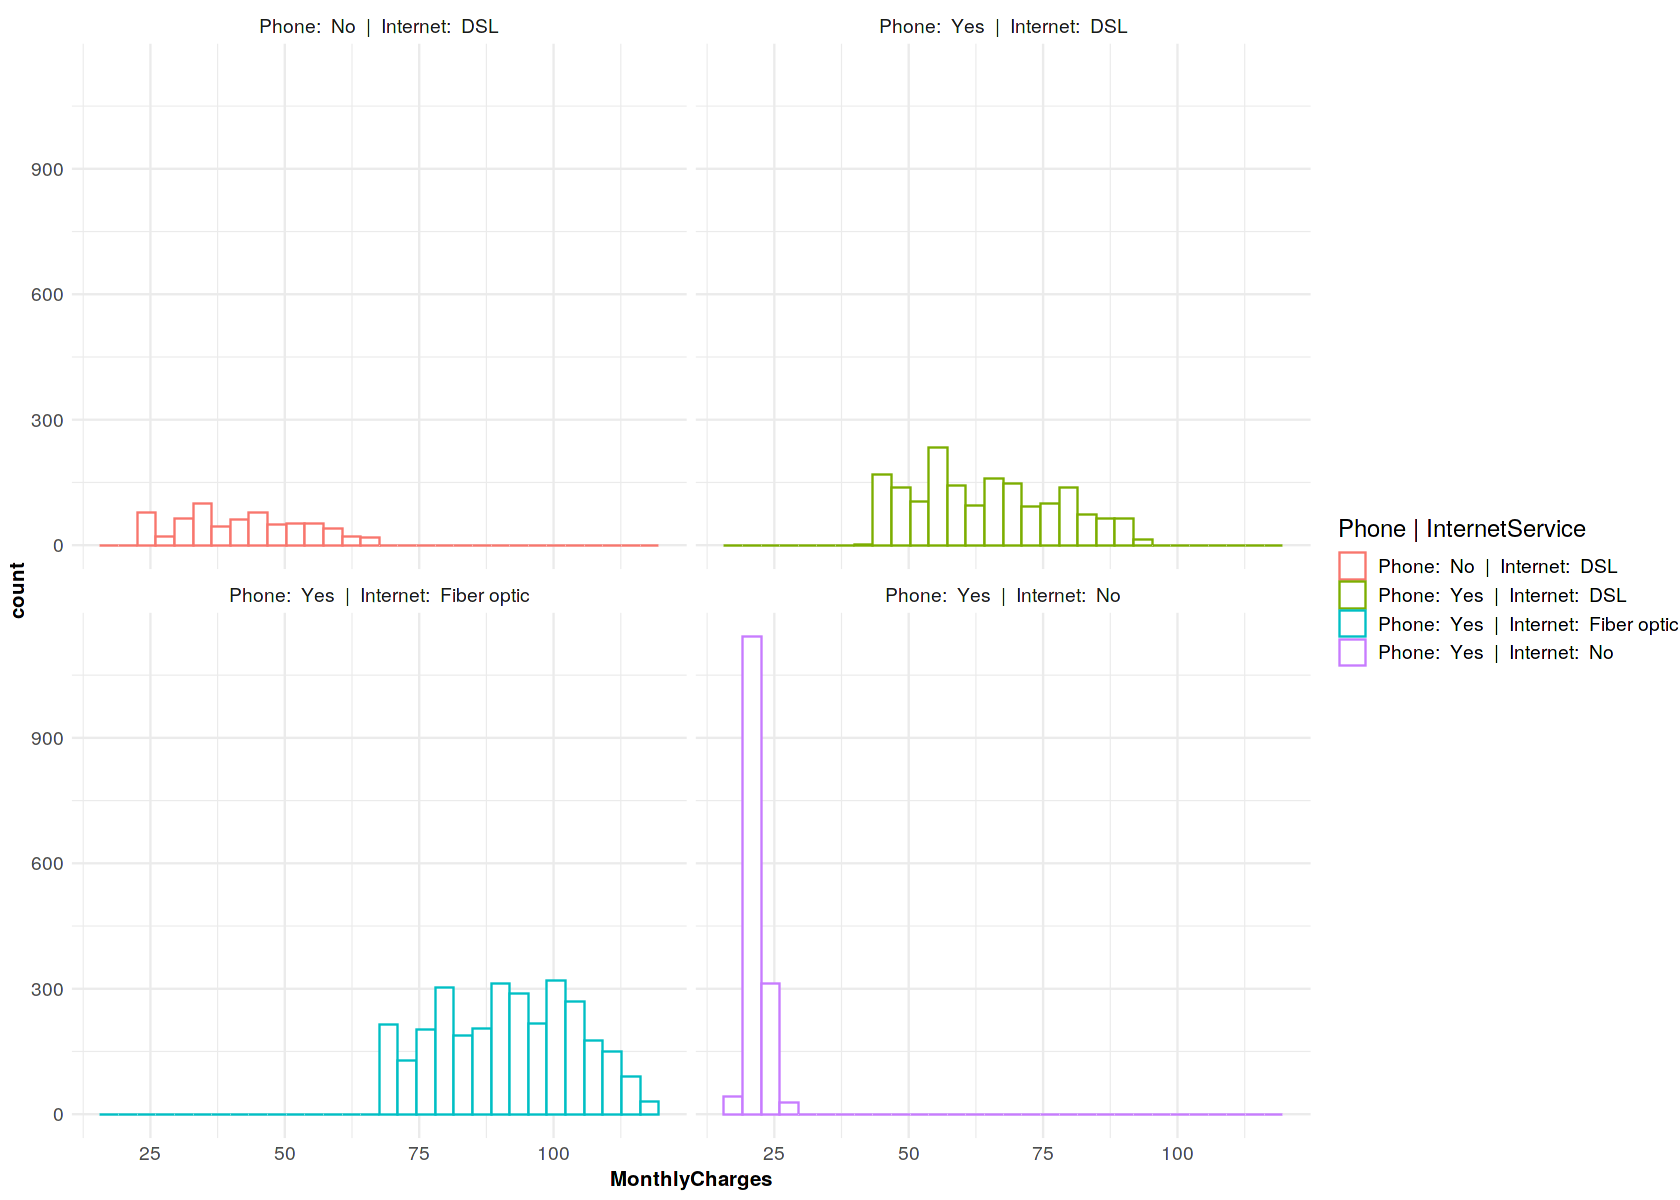

In [12]:
# How about the combination of the two - Contingency Table
telco_df$InternetPhoneServices <- paste('Phone: ', telco_df$PhoneService, ' | ',
                                        'Internet: ', telco_df$InternetService
                                       ) 
                                        
ggplot(telco_df, aes(x=MonthlyCharges, color=InternetPhoneServices)) +
  geom_histogram(fill="white", alpha=0.5, position="identity") + theme_minimal() + 
    ggtitle("`MonthlyCharges` by `PhoneService` and `InternetService`") + 
    theme(axis.title=element_text(size=12,face="bold")) + 
    theme(text = element_text(size = 14)) +
    labs(color="Phone | InternetService")


ggplot(telco_df, aes(x = MonthlyCharges)) + 
    geom_histogram(fill="white", aes(color=InternetPhoneServices)) + theme_minimal() + 
    facet_wrap( ~ InternetPhoneServices) + 
    theme(axis.title=element_text(size=12,face="bold")) + 
    theme(text = element_text(size = 14)) +
    labs(color="Phone | InternetService")

In [13]:
# TODO: statistical check on whether the distributions are coming from different populations.

---
### <font color = 'darkslateblue'> 2.3. Is `TotalCharges` equal to `Tenrue`*`MonthlyCharges`?</font>
* We will check if the total charges computed by `MonthlyCharges` * `Tenure` (in number of months) is identical to the actual `TotalCharges` in the data. 
* Method: 
    1. Compute theoretical total charges `total_charges_theoretical` = `MonthlyCharges` * `Tenure`. 
    2. Take the difference between `total_charges_theoretical` and `TotalCharges`. Save to `total_charges_diff`.
    3. Analyze the distribution of `total_charges_diff`. 


Warning message:
“Removed 11 rows containing non-finite values (stat_bin).”


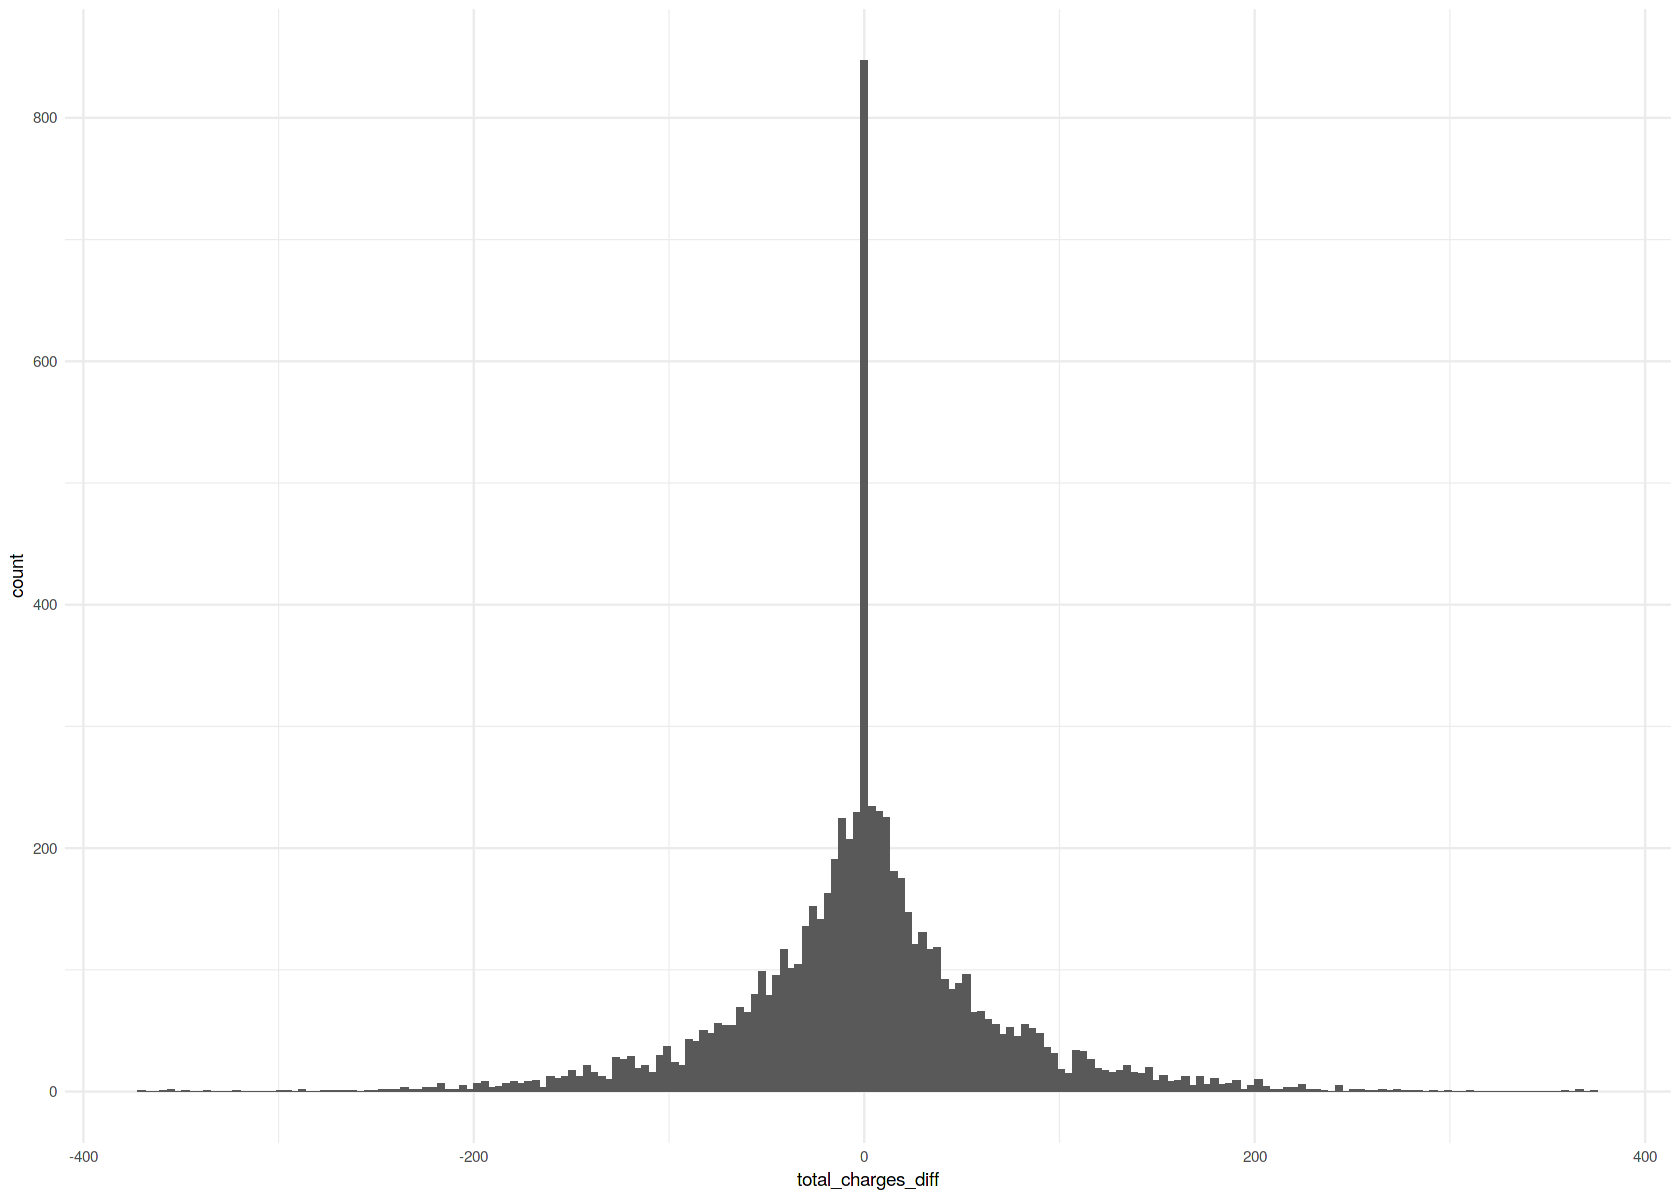

In [14]:
# 1. Compute theoretical total charges total_charges_theoretical = MonthlyCharges * Tenure.
telco_df <- telco_df %>% mutate(total_charges_theoretical = tenure*MonthlyCharges)

# 2. Take the difference between total_charges_theoretical and TotalCharges. Save to total_charges_diff.
telco_df <- telco_df %>% mutate(total_charges_diff = TotalCharges - total_charges_theoretical)

# 3. Analyze the distribution of total_charges_diff - let's start with a histogram
ggplot(telco_df, aes(total_charges_diff)) + geom_histogram(bins = 200) + theme_minimal()

**OBSERVATION:**  
* We have a sharp vertical bar at 0. 
* The distribution of the rest of the values look close to a normal distribuion (let's check this just for fun!). 

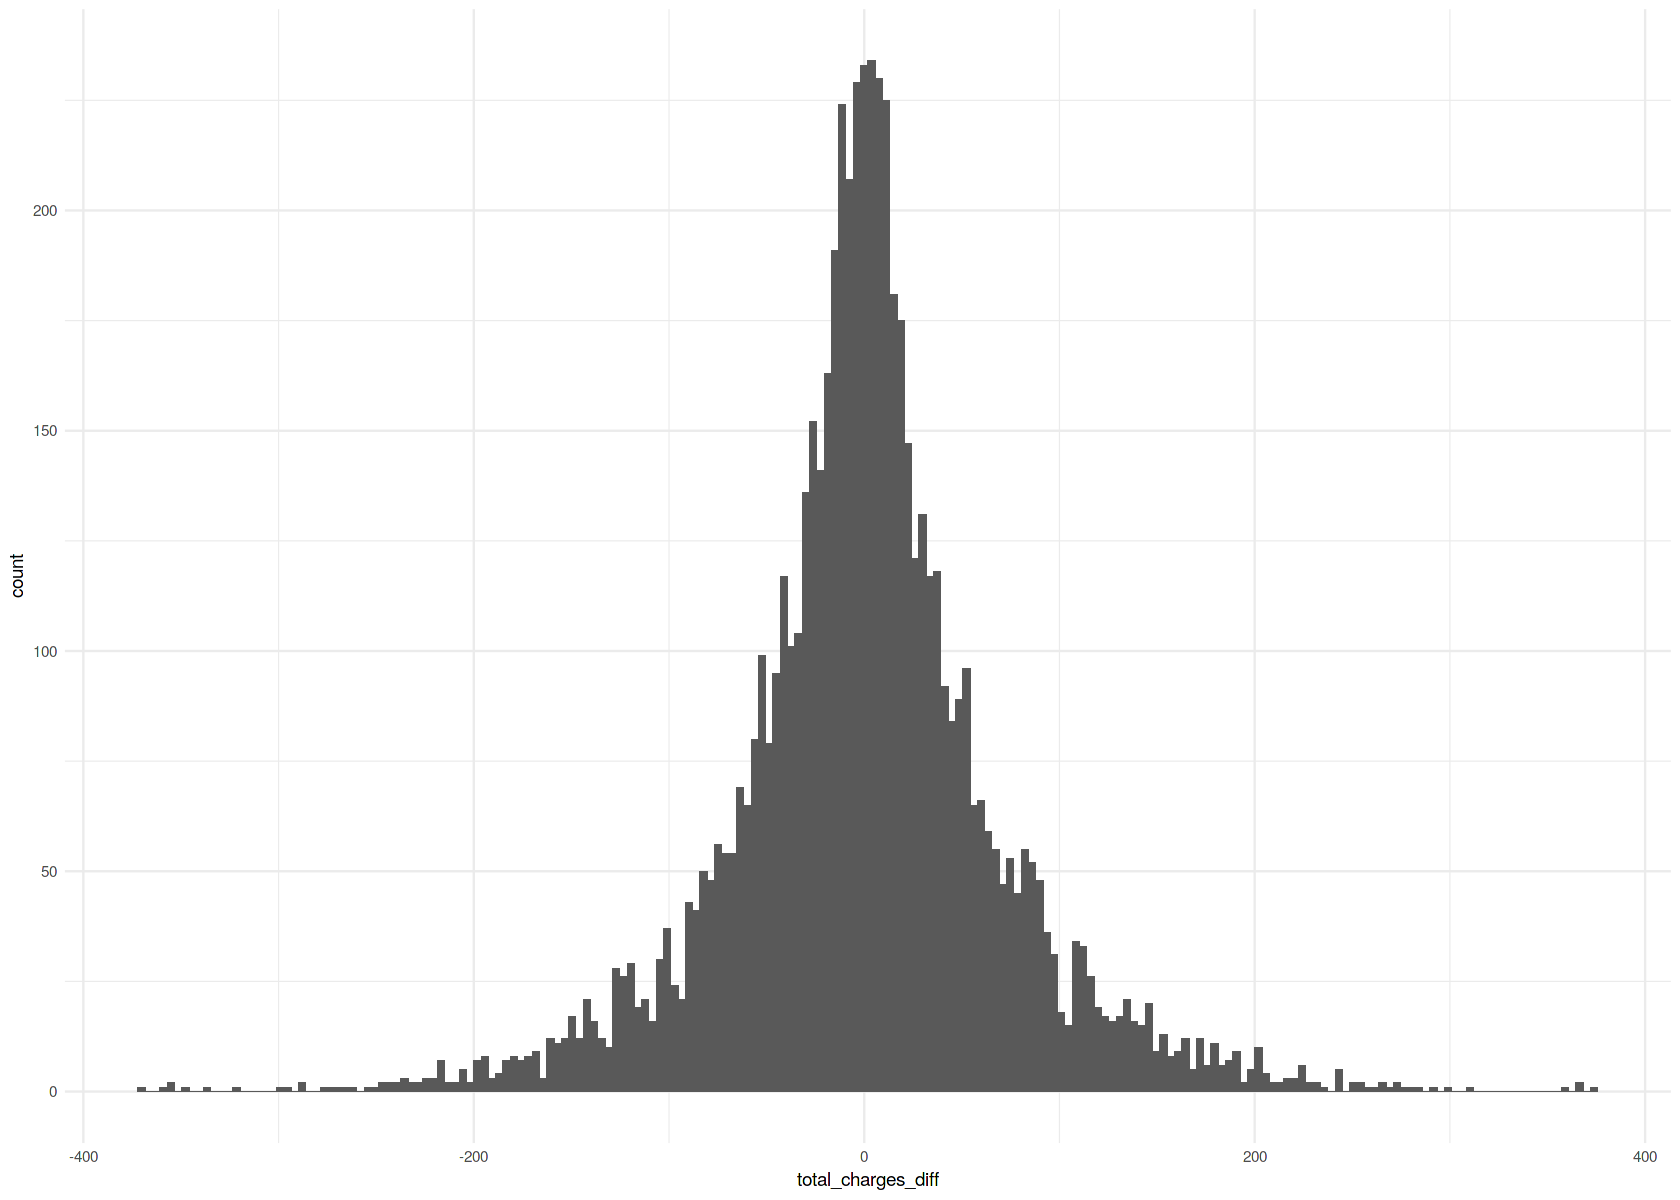

In [15]:
# remove 0 and plot histogram 
diff_hist_data <- telco_df %>% 
    filter(total_charges_diff != 0)
ggplot(diff_hist_data, aes(total_charges_diff)) + geom_histogram(bins = 200) + theme_minimal()

**OBSERVATION:**  
* Looks roughly normal? 
* This is a good time to test out normality testing methods. 
    * Method 1: QQ-Plot 
    * Method 2: Kolmogorov-Smirnov test 
    * Method 3: Anderson-Darling test

[1] 1297 1600

Warning message in ks.test(diff_hist_data$total_charges_diff, "pnorm", 0, sd(diff_hist_data$total_charges_diff)):
“ties should not be present for the Kolmogorov-Smirnov test”



	One-sample Kolmogorov-Smirnov test

data:  diff_hist_data$total_charges_diff
D = 0.070153, p-value < 2.2e-16
alternative hypothesis: two-sided



	Anderson-Darling normality test

data:  diff_hist_data$total_charges_diff
A = 74.325, p-value < 2.2e-16


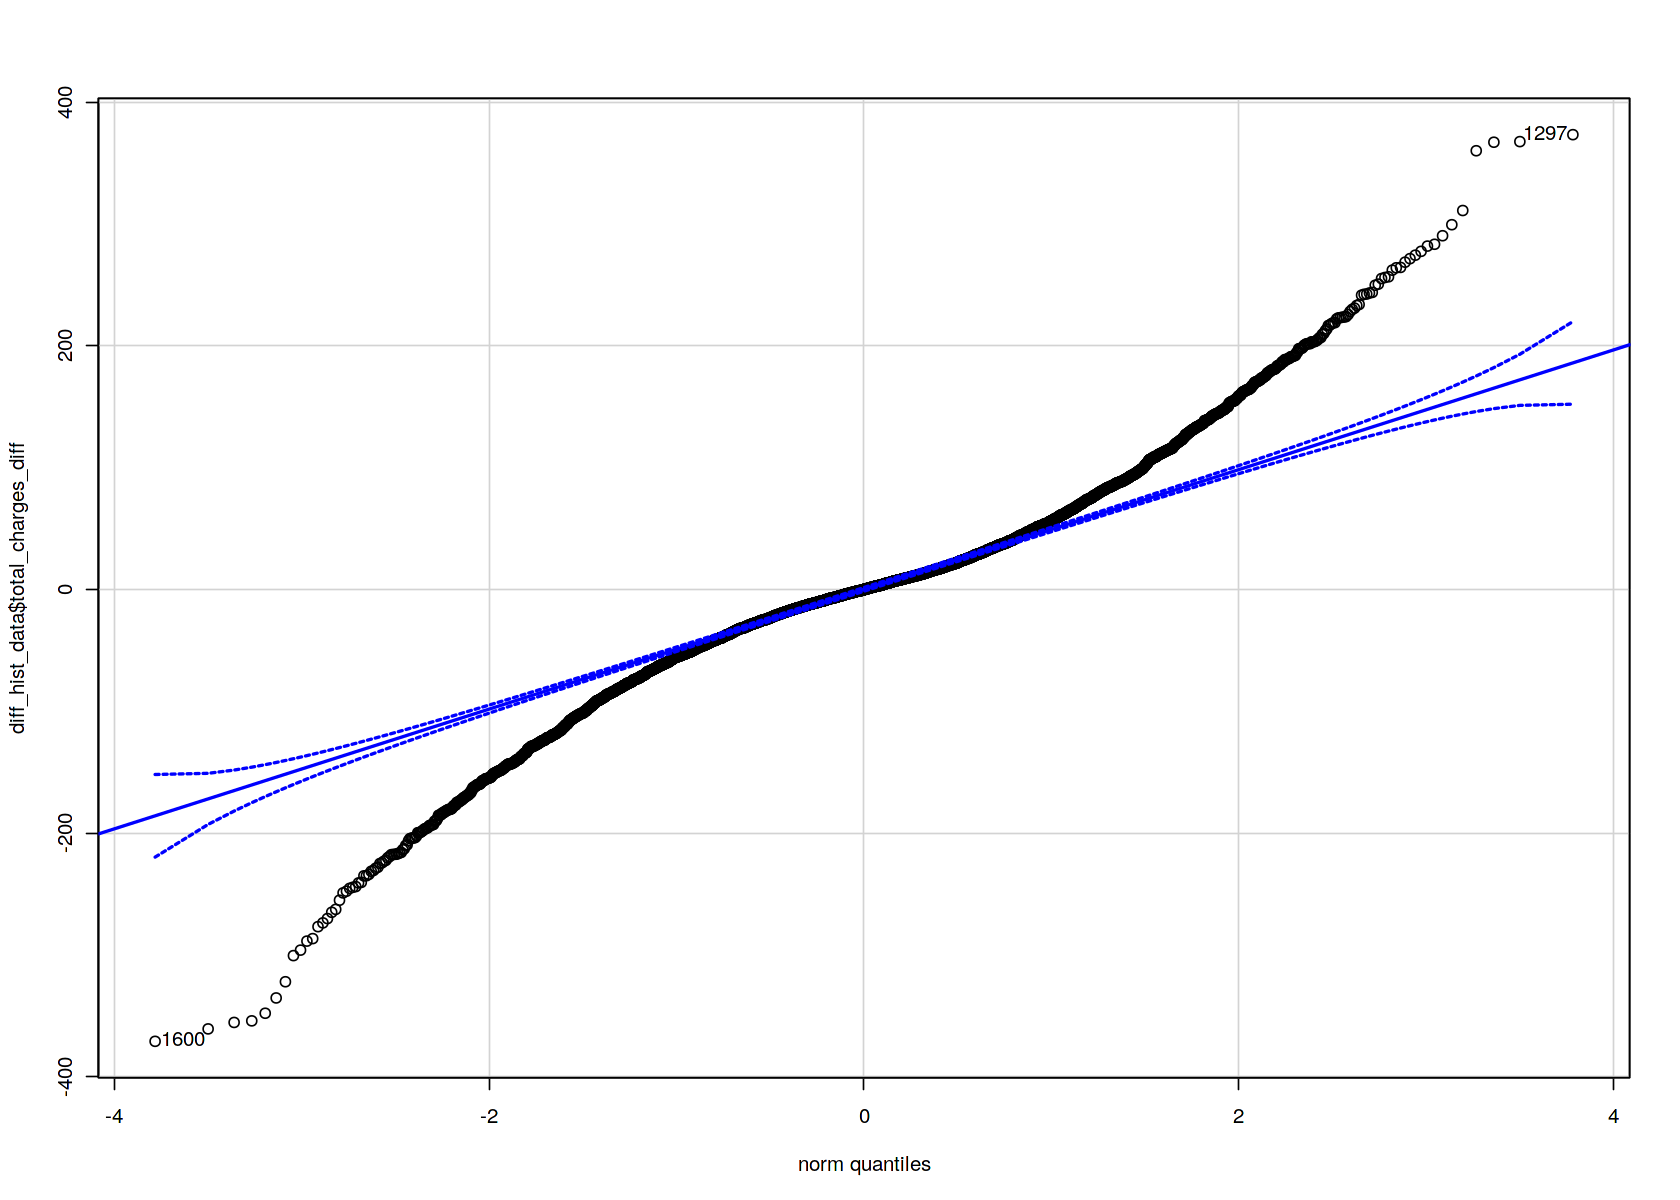

In [16]:
# Method 1: QQ-Plot 
qqPlot(diff_hist_data$total_charges_diff)

# Method 2: Kolmogorov-Smirnov test
# ref: https://stackoverflow.com/questions/26715843/kolmogorov-smirnov-test-in-r
ks.test(diff_hist_data$total_charges_diff, 'pnorm', 0, sd(diff_hist_data$total_charges_diff))

# Method 3: Anderson-Darling test
ad.test(diff_hist_data$total_charges_diff)

**OBSERVATIONS:**
* QQ-plot indicates that the distribution has light tails. 
    * ref: 
        * https://www.youtube.com/watch?v=vMaKx9fmJHE
        * https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
* Both KS and AD normality tests indicate that there is not enough evidence to concluse the distribution is not normal.


(TODO) other side question(s): 
* What features are related to the difference in the theoretical and actual total charges? 
    1. Divide the difference in theoretical - actual total charges by tenure to obtain monthly difference (how much more or less one paid compared to the mean). 
    2. Conduct regression method to see which feature(s) are related to the difference. Something like a regression _y(difference) ~ x1(tenure) + x2(PhoneService) + ... + xn_
    3. potential conclusion: Is tenure negatively correlated with monthly charge difference? Longer tenure result in a larger discount?
    

---
### <font color = 'darkslateblue'> 1.2. Bivariate Data Exploration</font>

Clearly independent categorical features: 

_Fisher's exact test is more accurate than the chi-square test or G–test of independence when the expected numbers are small. I recommend you use Fisher's exact test when the total sample size is less than 1000, and use the chi-square or G–test for larger sample sizes._
ref: http://www.biostathandbook.com/fishers.html#:~:text=Fisher's%20exact%20test%20is%20more,test%20for%20larger%20sample%20sizes.

In [17]:
table(telco_df$InternetService, telco_df$MultipleLines)

             
                No No phone service  Yes
  DSL         1048              682  691
  Fiber optic 1158                0 1938
  No          1184                0  342

In [18]:
table(telco_df$MultipleLines, telco_df$PhoneService)

                  
                     No  Yes
  No                  0 3390
  No phone service  682    0
  Yes                 0 2971

In [19]:
table(telco_df$OnlineSecurity, telco_df$OnlineBackup)

                     
                        No No internet service  Yes
  No                  2195                   0 1303
  No internet service    0                1526    0
  Yes                  893                   0 1126

In [20]:
table(telco_df$Partner, telco_df$Dependents)
fisher.test(telco_df$Partner, telco_df$Dependents)

     
        No  Yes
  No  3280  361
  Yes 1653 1749


	Fisher's Exact Test for Count Data

data:  telco_df$Partner and telco_df$Dependents
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  8.447856 10.950901
sample estimates:
odds ratio 
  9.607857 


**OBSERVATION:** At significance level of 5%, we reject the null hypothesis that there is significant relationship between `Partner` and `Dependents`. 

In [21]:
table(telco_df$Partner, telco_df$MultipleLines)
fisher.test(telco_df$Partner, telco_df$MultipleLines)

     
        No No phone service  Yes
  No  1981              371 1289
  Yes 1409              311 1682


	Fisher's Exact Test for Count Data

data:  telco_df$Partner and telco_df$MultipleLines
p-value < 2.2e-16
alternative hypothesis: two.sided


**OBSERVATION:** At significance level of 5%, we reject the null hypothesis that there is significant relationship between Partner and Dependents.

In [22]:
table(telco_df$Dependents, telco_df$MultipleLines)
fisher.test(telco_df$Dependents, telco_df$MultipleLines)

     
        No No phone service  Yes
  No  2337              476 2120
  Yes 1053              206  851


	Fisher's Exact Test for Count Data

data:  telco_df$Dependents and telco_df$MultipleLines
p-value = 0.1082
alternative hypothesis: two.sided


**OBSERVATION:** At significance level of 5%, we fail to reject the null hypothesis that there is significant relationship between `Dependents` and `MultipleLines`.   

Which makes sense as having dependents likely means there is a need for multiple lines.

**OBSERVATION:** At significance level of 5%, we fail to reject the null hypothesis that there is significant relationship between `Dependents` and `MultipleLines`.   

Which makes sense as having dependents likely means there is a need for multiple lines.

TODO: Correspondence Analysis

---
## <font color = 'crimson'> Analysis 1 - Survival Analysis </font>
* Kaplan-Meier Cuve: Probability curve in survival analysis 
* Cox Proportional-Hazard (PH): Hypothesis testing in survival analysis 
* Log Rank Test: Regression in survival analysis

(TODO): Add Explanation

### <font color = 'darkslateblue'> Analysis 1.1. Kaplan-Meier & Logrank </font>

The null hypothesis in Logrank test states that _there is no difference between the populations in the probability of an event (here a churn)_

ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC403858/#:~:text=The%20logrank%20test%20is%20used,of%20events%20(here%20deaths).

In [23]:
# add 'is_churn' column to conduct survival anlaysis 
telco_df$is_churn <- ifelse(telco_df$Churn == 'Yes', 1, 0)

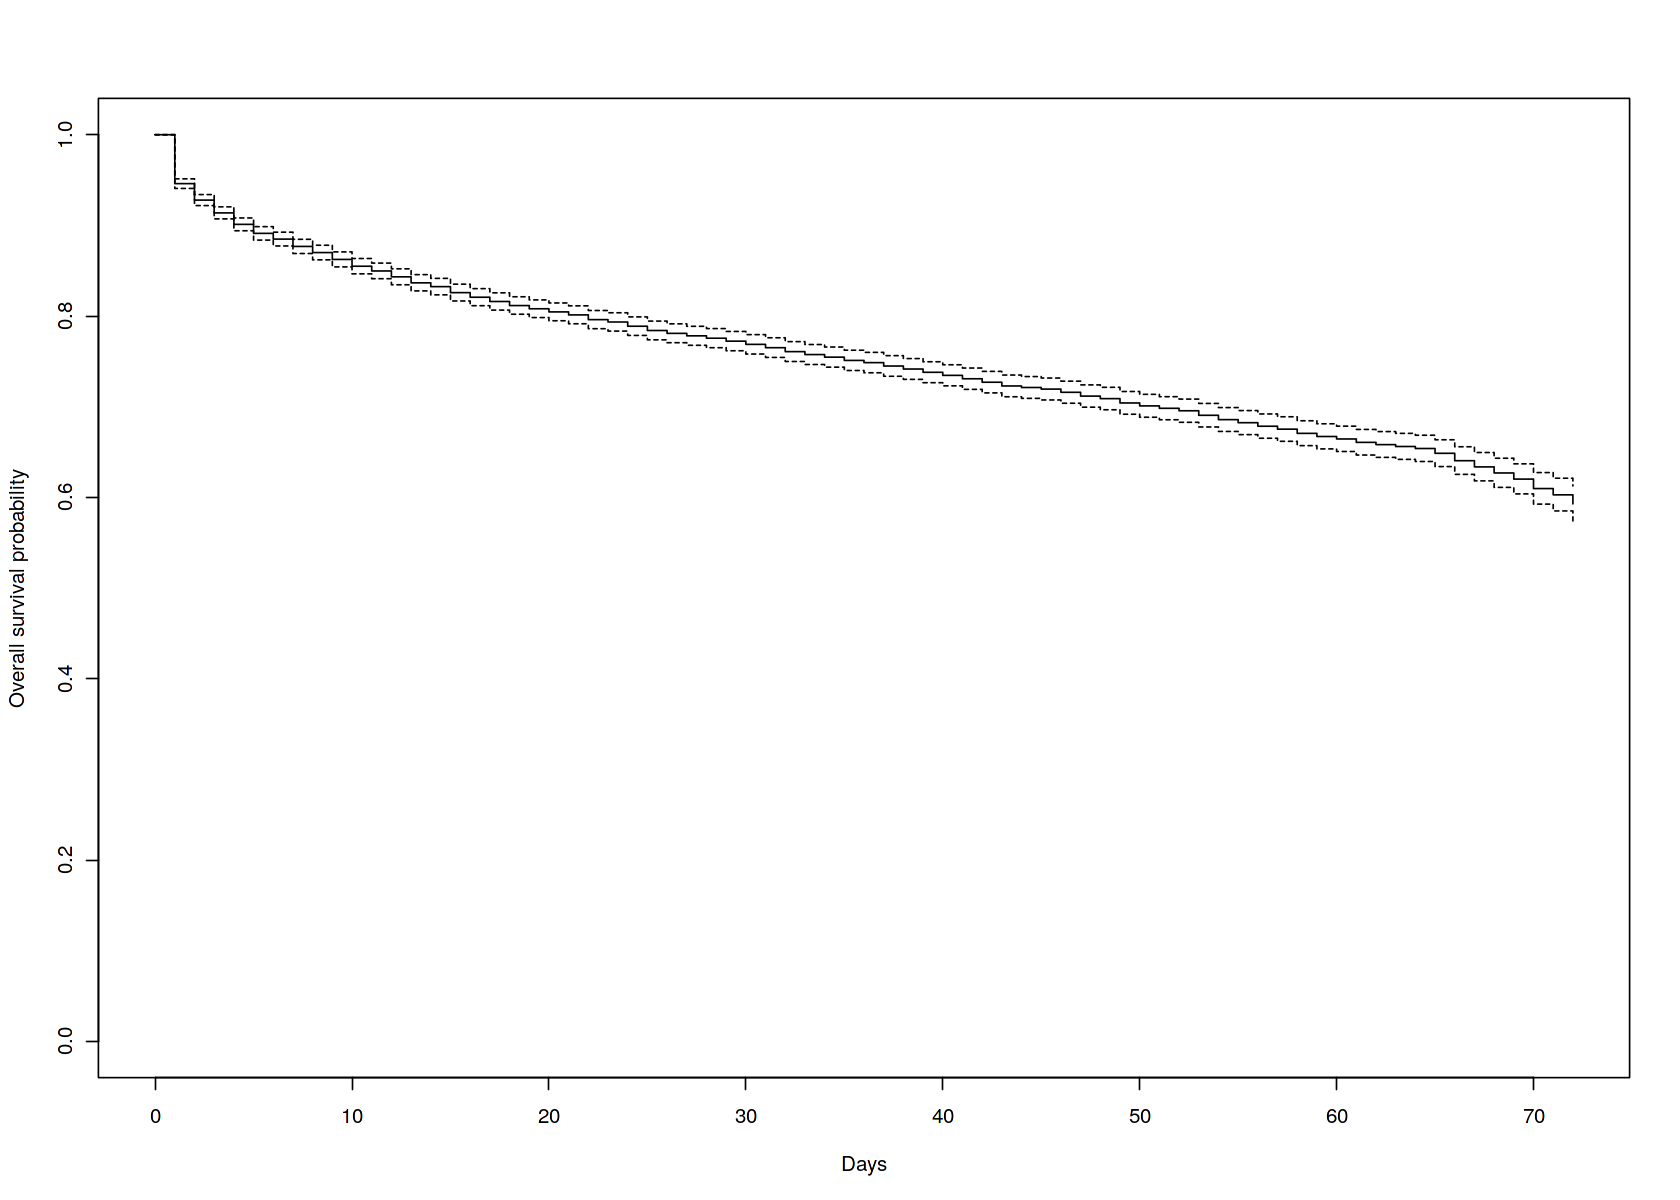

In [24]:
# check N/A in each column. 
plot(survfit(Surv(tenure, is_churn) ~ 1, data = telco_df), 
     xlab = "Days", 
     ylab = "Overall survival probability")

In [25]:
surv_object <- Surv(time = telco_df$tenure, event = telco_df$is_churn)

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


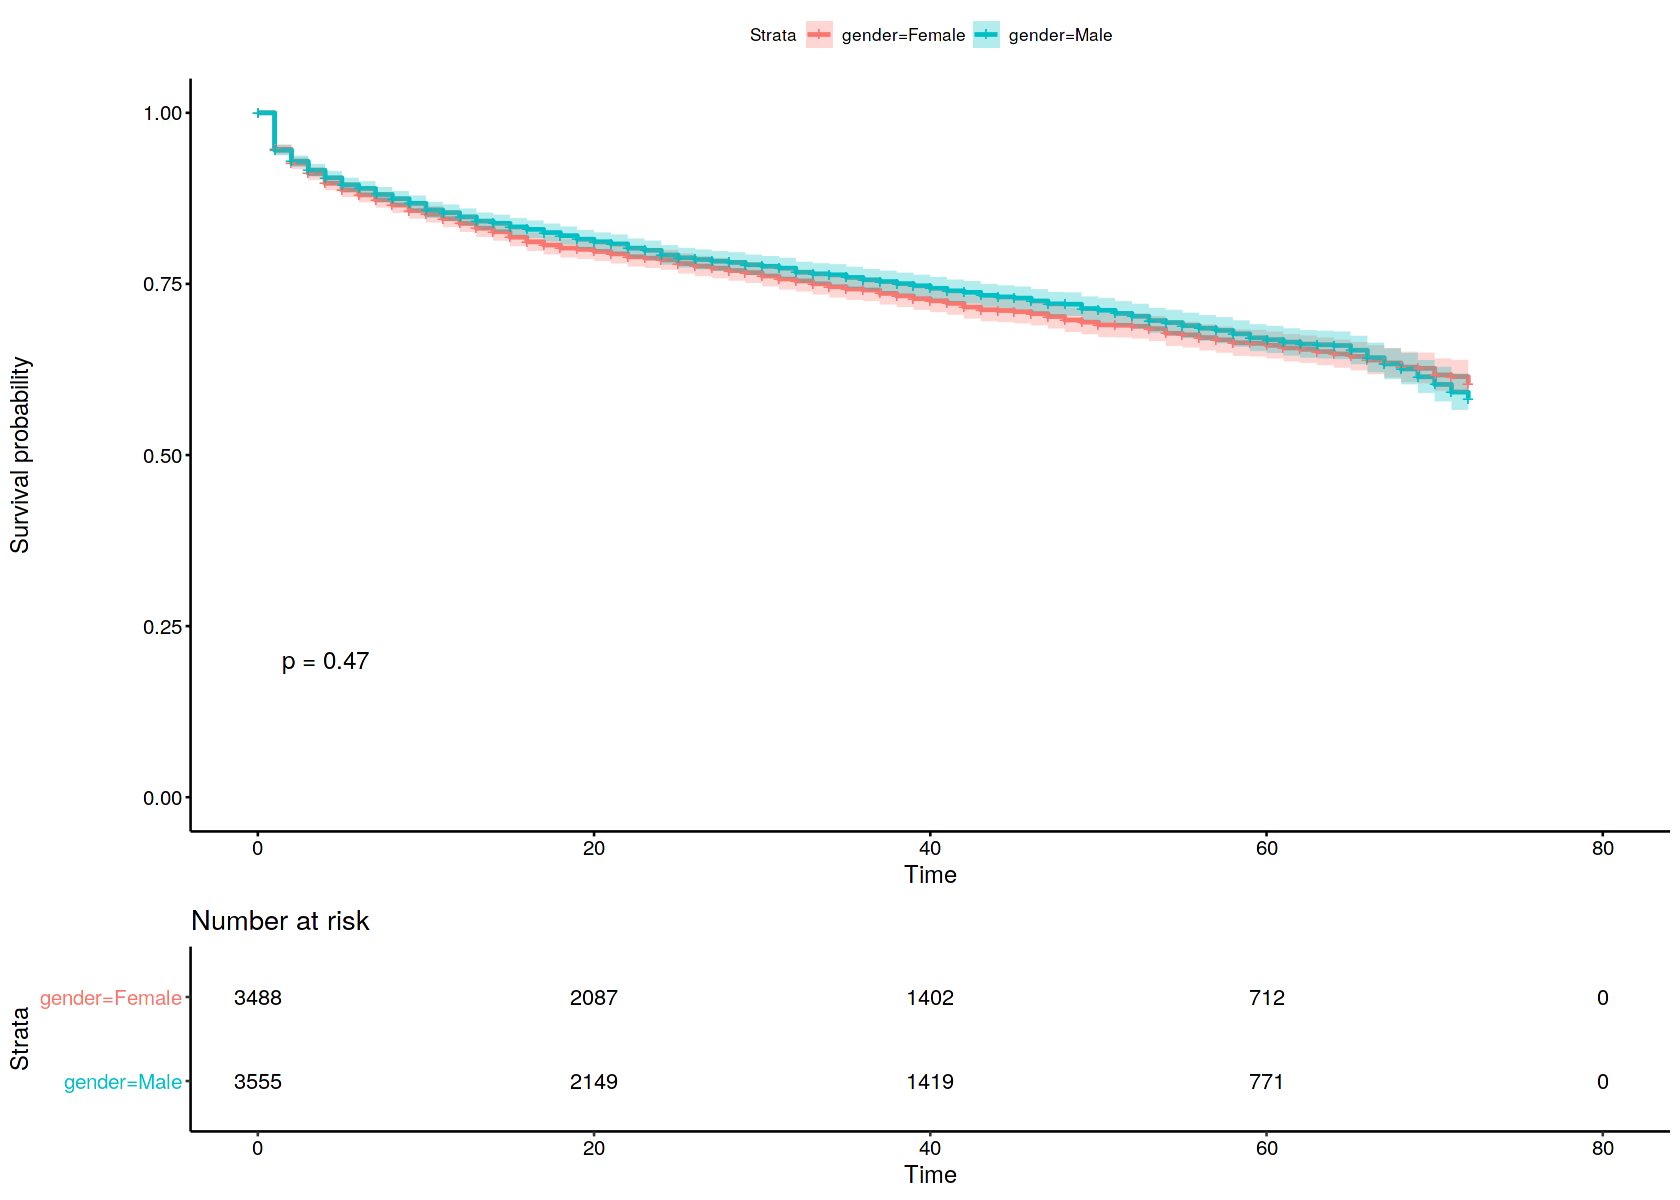

In [26]:
fit <- survfit(surv_object ~ gender, data = telco_df)
ggsurvplot(fit, data = telco_df, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE
          )

**OBSERVATION:**  
The evidence is **not sufficient** to reject the null hypothesis.  
Null hypothesis: `Gender` is _not_ a factor that distinguishes the probability to churn. 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


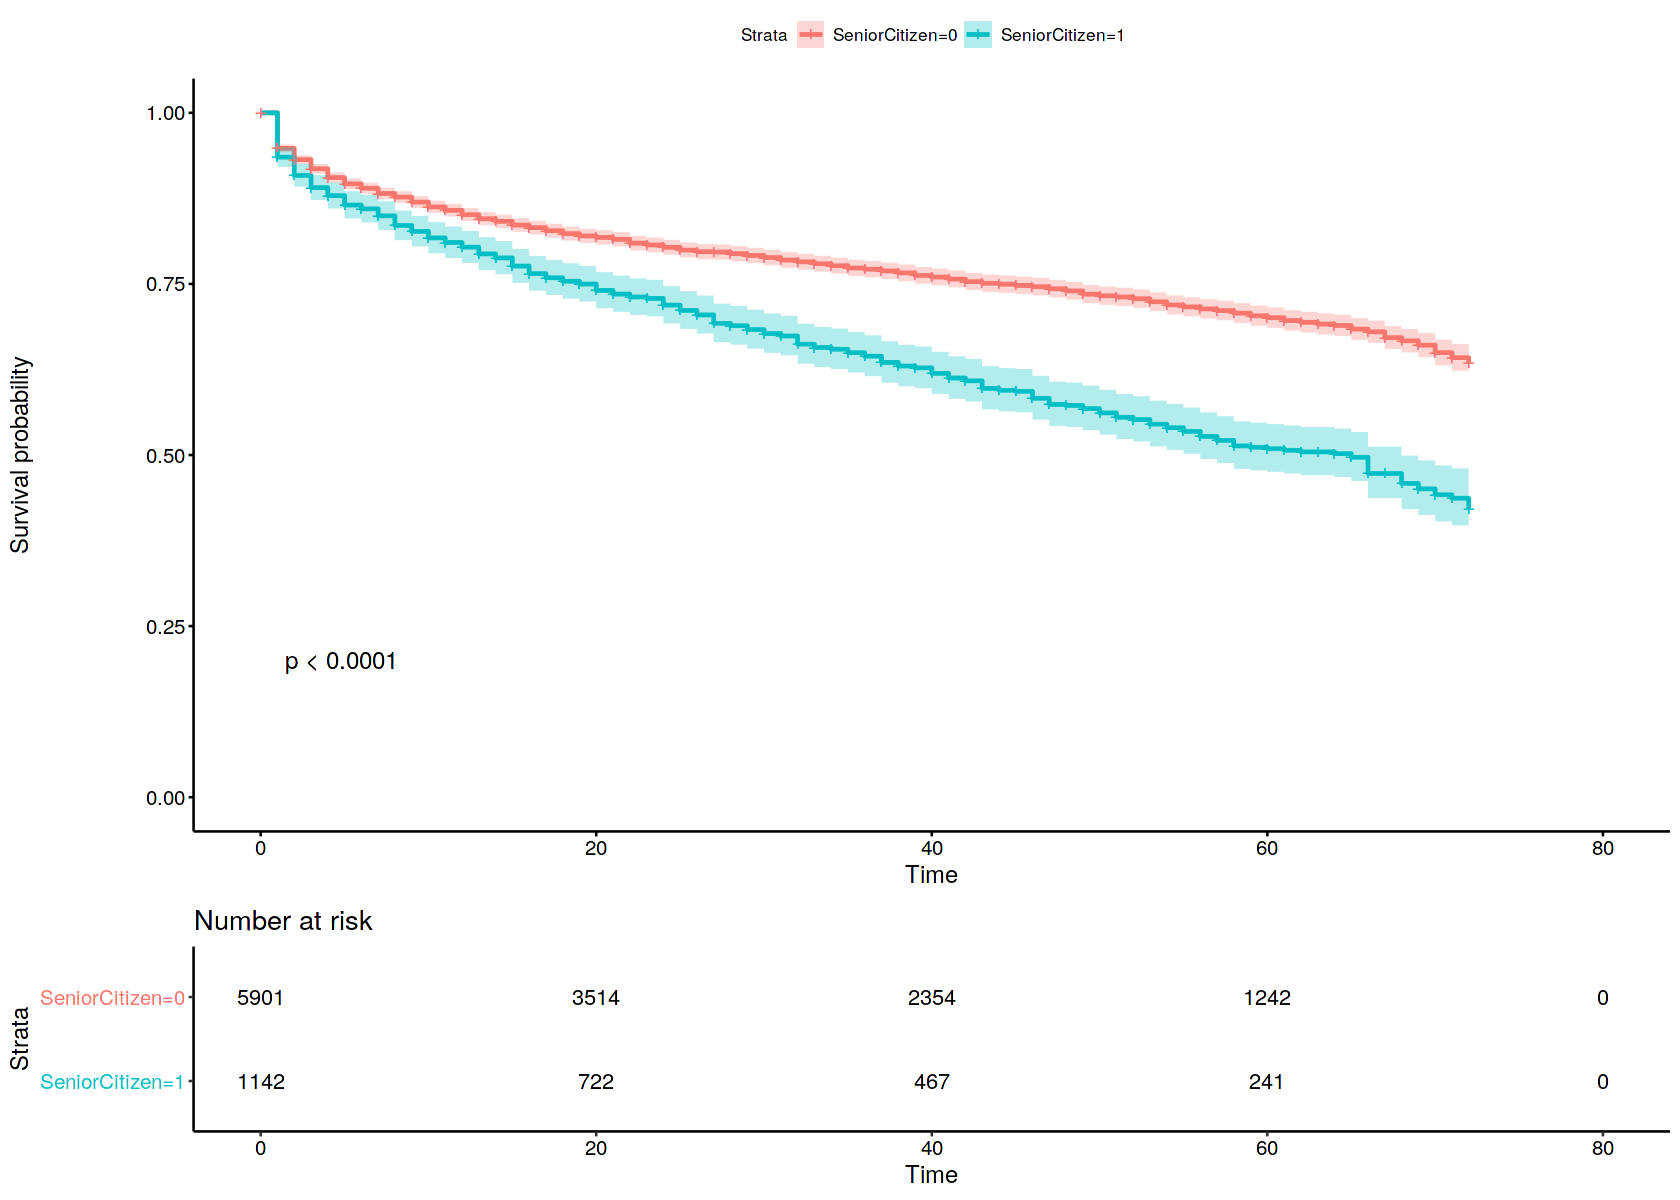

In [27]:
fit1 <- survfit(surv_object ~ SeniorCitizen, data = telco_df)
ggsurvplot(fit1, data = telco_df, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)

**OBSERVATION:** 

The evidence **is** sufficient to reject the null hypothesis.  
Null hypothesis: `SeniorCitizen` is _not_ a factor that distinguishes the probability to churn. 


Non-senior citizens (`SeniorCitizen` = 0) are more likely to stay longer with the Telco service.  
The difference in the probabilities between the Senior and non-Senior Citizens staying with Telco service becomes more different as the tenure gets longer.
Staying with the firm for 60 weeks is ~75% for non-senior citizens vs. ~50% for senior citiznes. 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


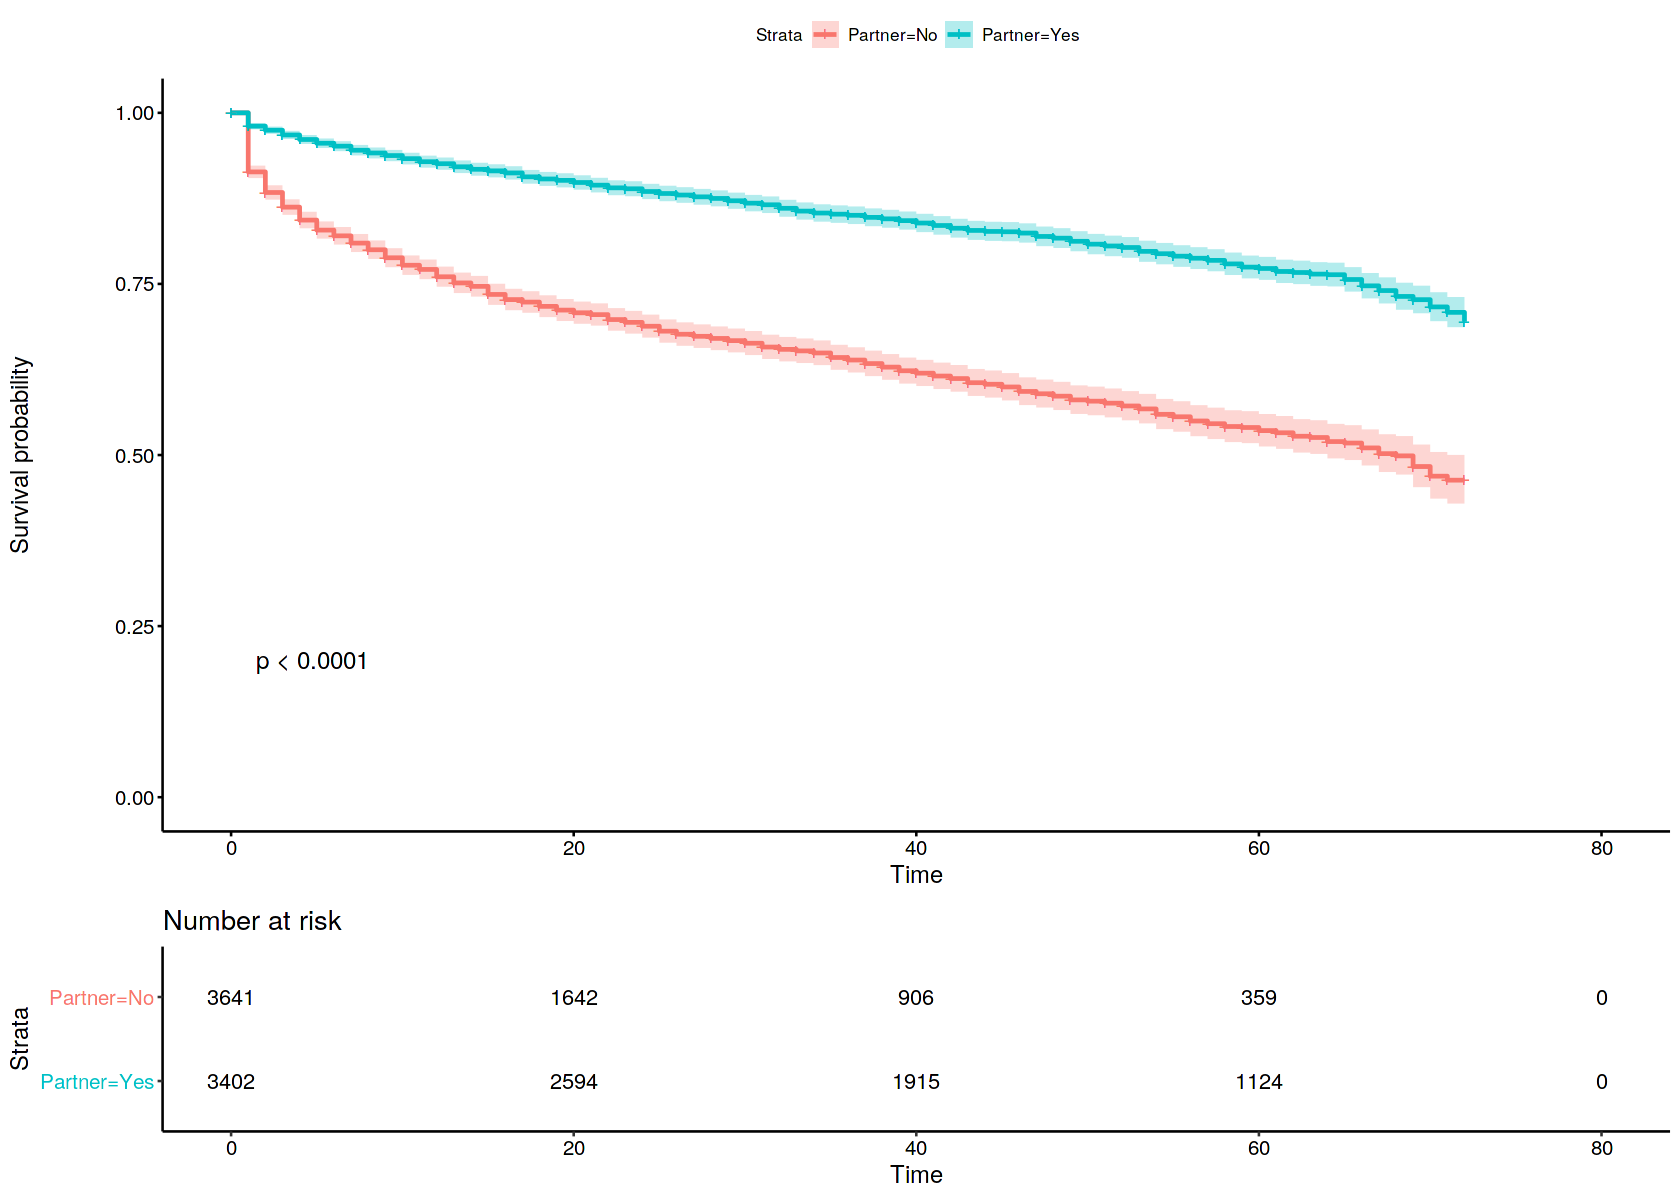

In [28]:
fit1 <- survfit(surv_object ~ Partner, data = telco_df)
ggsurvplot(fit1, data = telco_df, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)

**OBSERVATION:**  

The evidence **is** sufficient to reject the null hypothesis.  
Null hypothesis: Being a `Partner` is _not_ a factor that distinguishes the probability to churn.  
Customer that _are_ partners (`Partner` = 1) are more likely to stay longer with the Telco service. 


Different from `SeniorCitizen`, the difference in survival probability for `Partner` diverged quickly in the earlier tenure, and the difference in probability roughly identical (roughly parallel) throughout the tenures.  

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


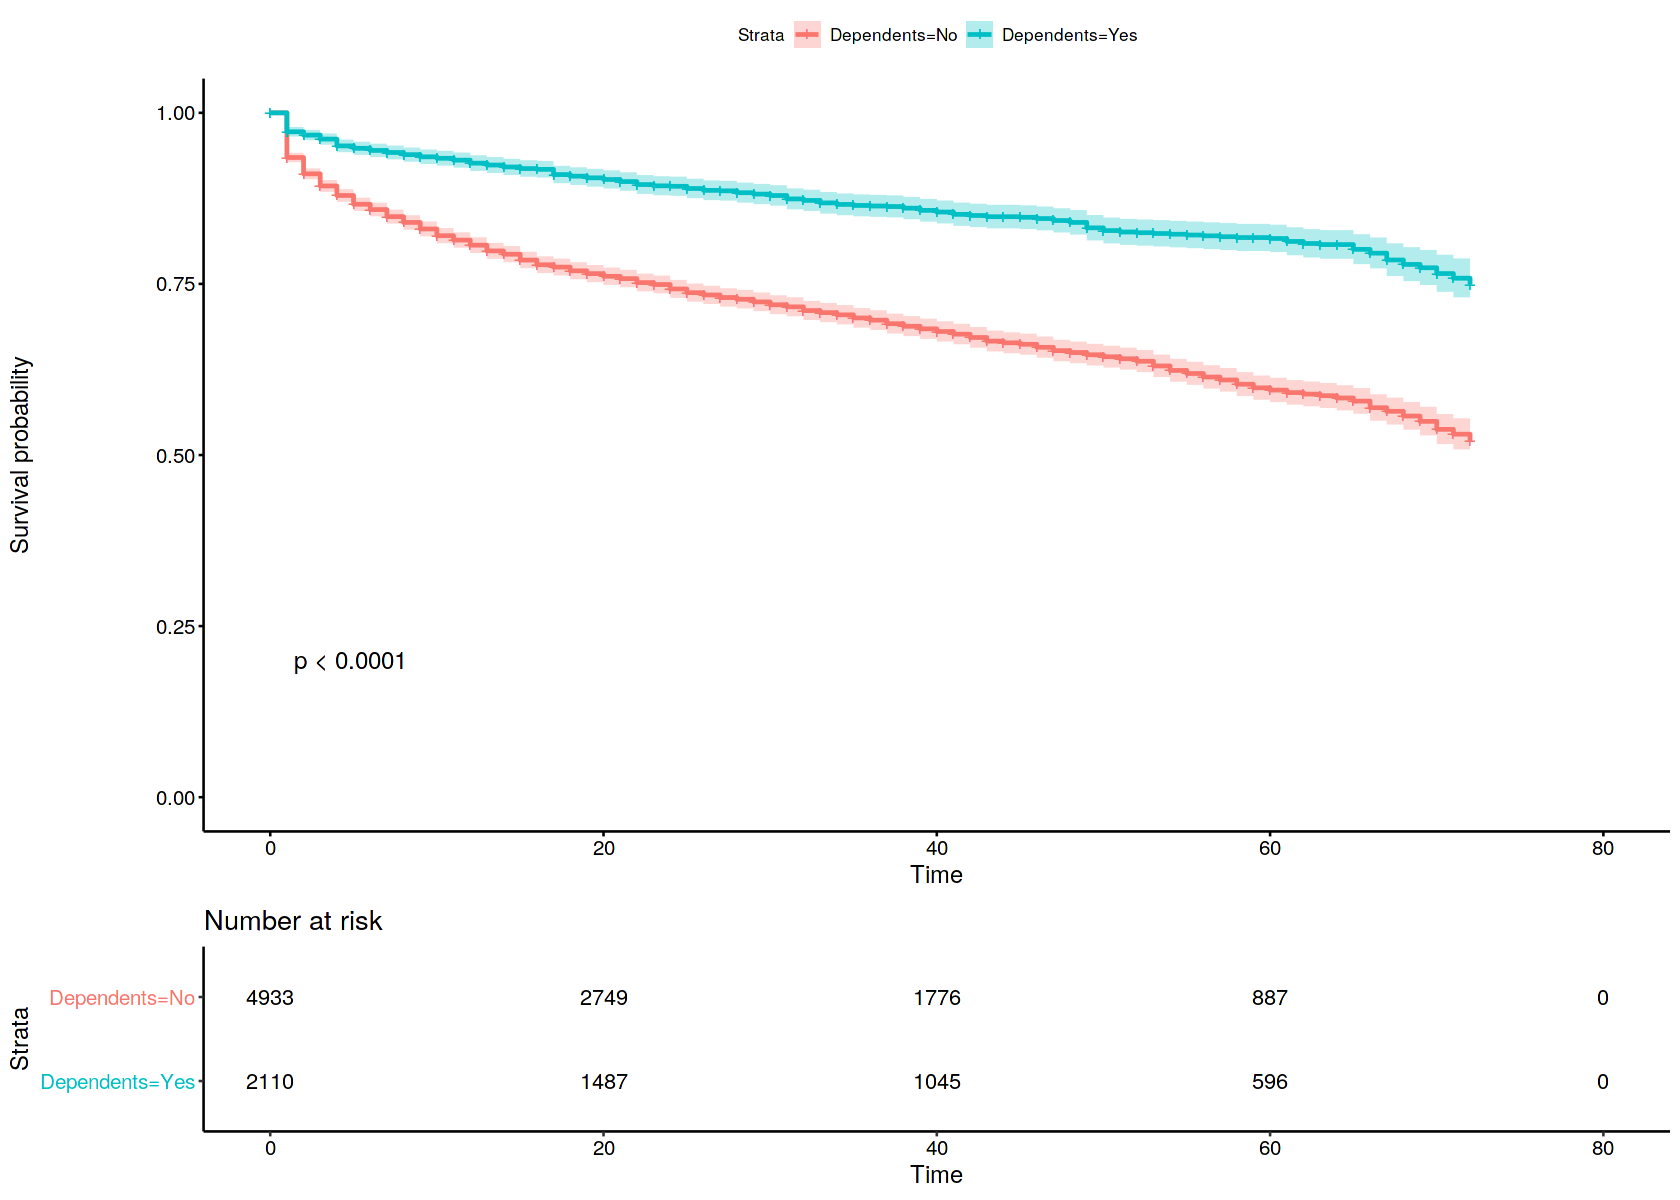

In [29]:
fit1 <- survfit(surv_object ~ Dependents, data = telco_df)
ggsurvplot(fit1, data = telco_df, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)

**OBSERVATION:**  
The evidence **is** sufficient to reject the null hypothesis.  
Null hypothesis: `Dependents` is _not_ a factor that distinguishes the probability to churn. 

Having `Dependents` is correlated with staying longer with the Telco service, meaning less likely to churn keeping the tenure identical.  

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


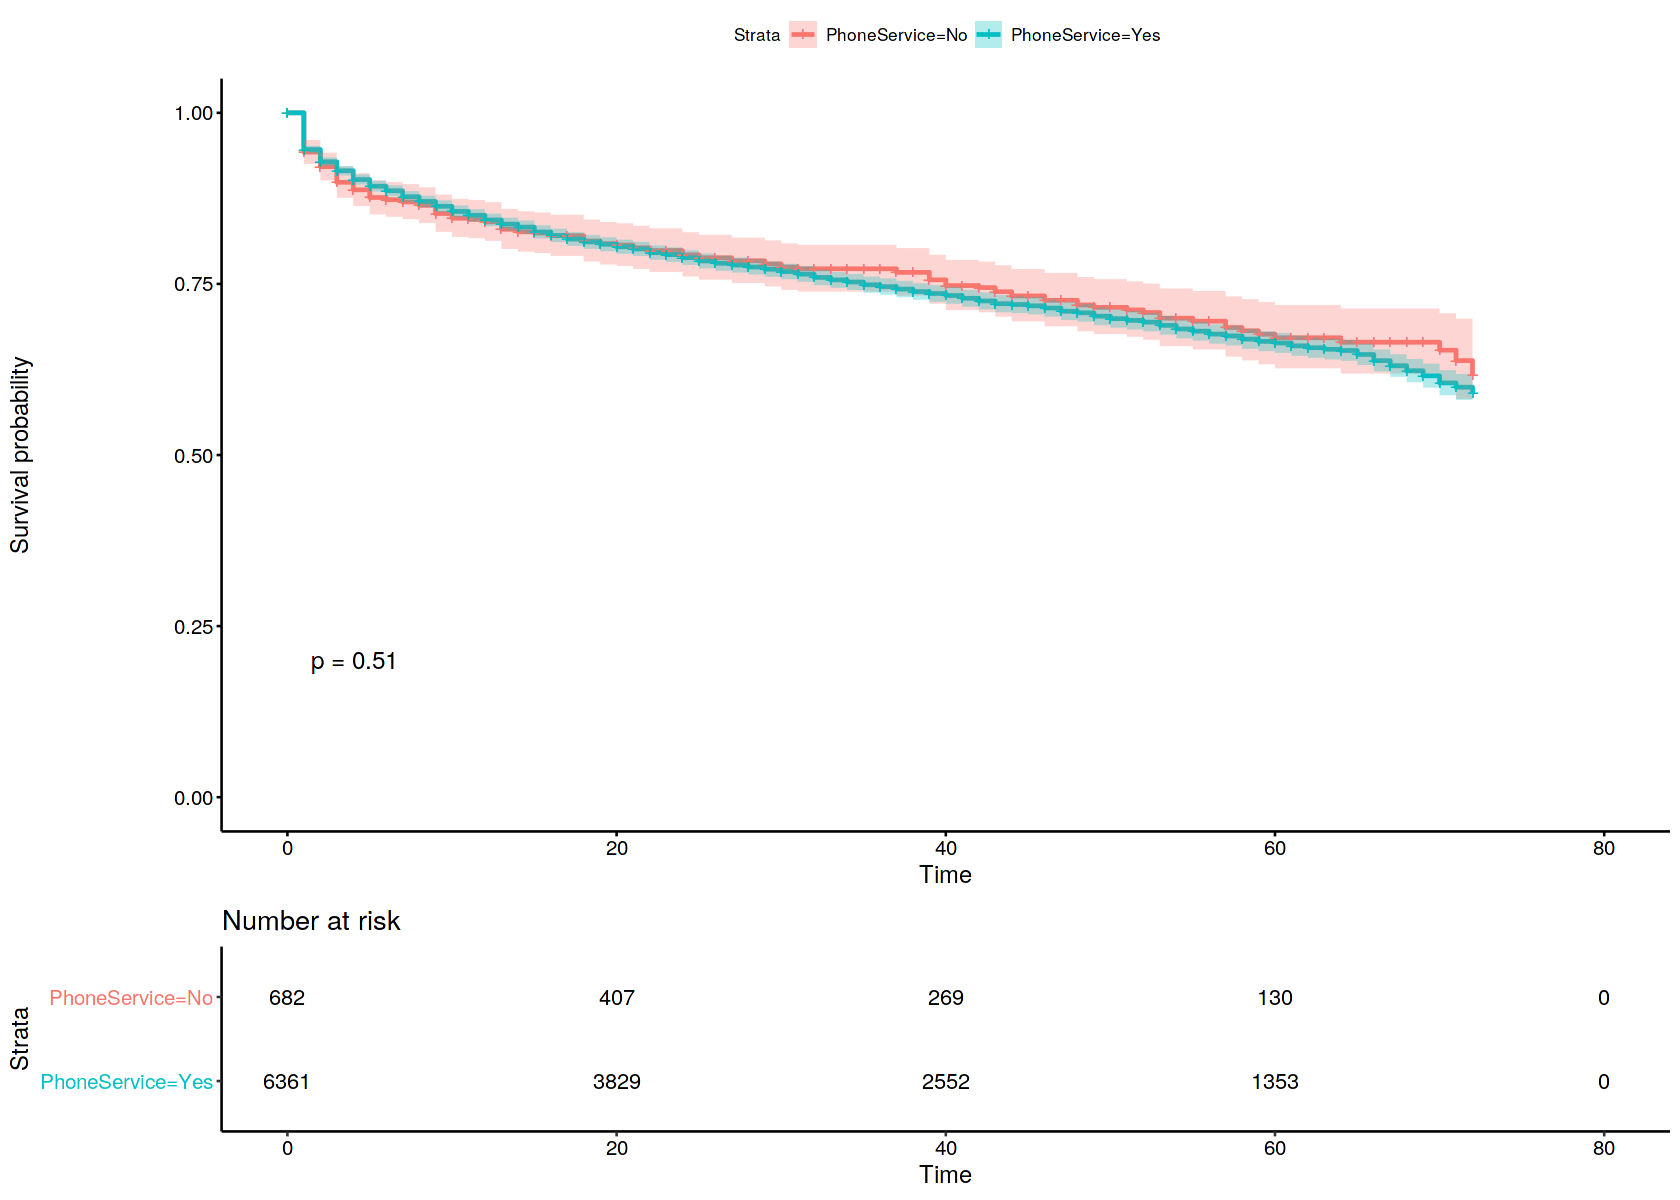

In [30]:
fit1 <- survfit(surv_object ~ PhoneService, data = telco_df)
ggsurvplot(fit1, data = telco_df, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)

**OBSERVATION:** 

The evidence is **not sufficient** to reject the null hypothesis.  
Null hypothesis: `PhoneService` is _not_ a factor that distinguishes the probability to churn. 

Telco should be aware that customer having a `PhoneService` is not a contributing factor to the customer's staying with the service. 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


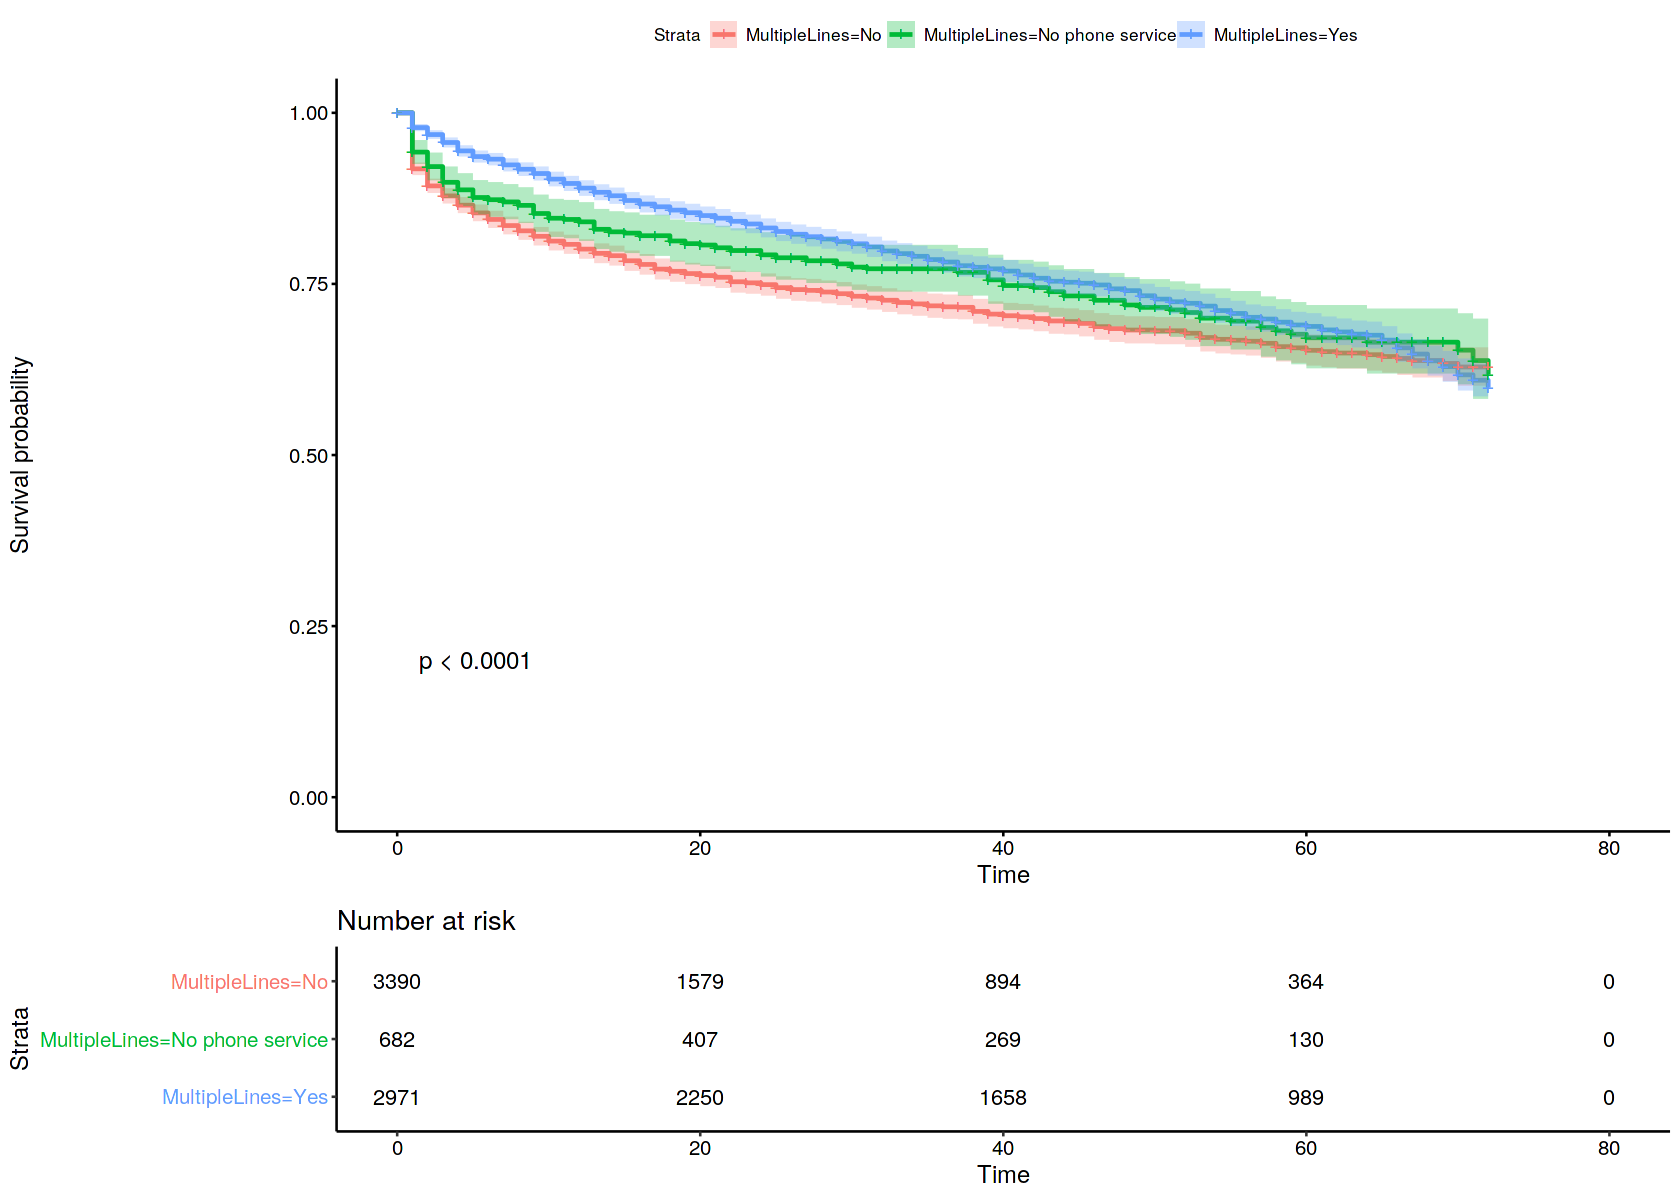

In [31]:
fit1 <- survfit(surv_object ~ MultipleLines, data = telco_df)
ggsurvplot(fit1, data = telco_df, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)

**OBSERVATION:** 

The evidence **is** sufficient to reject the null hypothesis.  
Null hypothesis: `MultipleLines` is _not_ a factor that distinguishes the probability to churn. 


What was interesting here was that the churn probability was in the following order:  
(most likely to get churned earlier) Single Line of phone service - No phone service - Multiple lines of phone service (least likely to get churned earlier)  

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


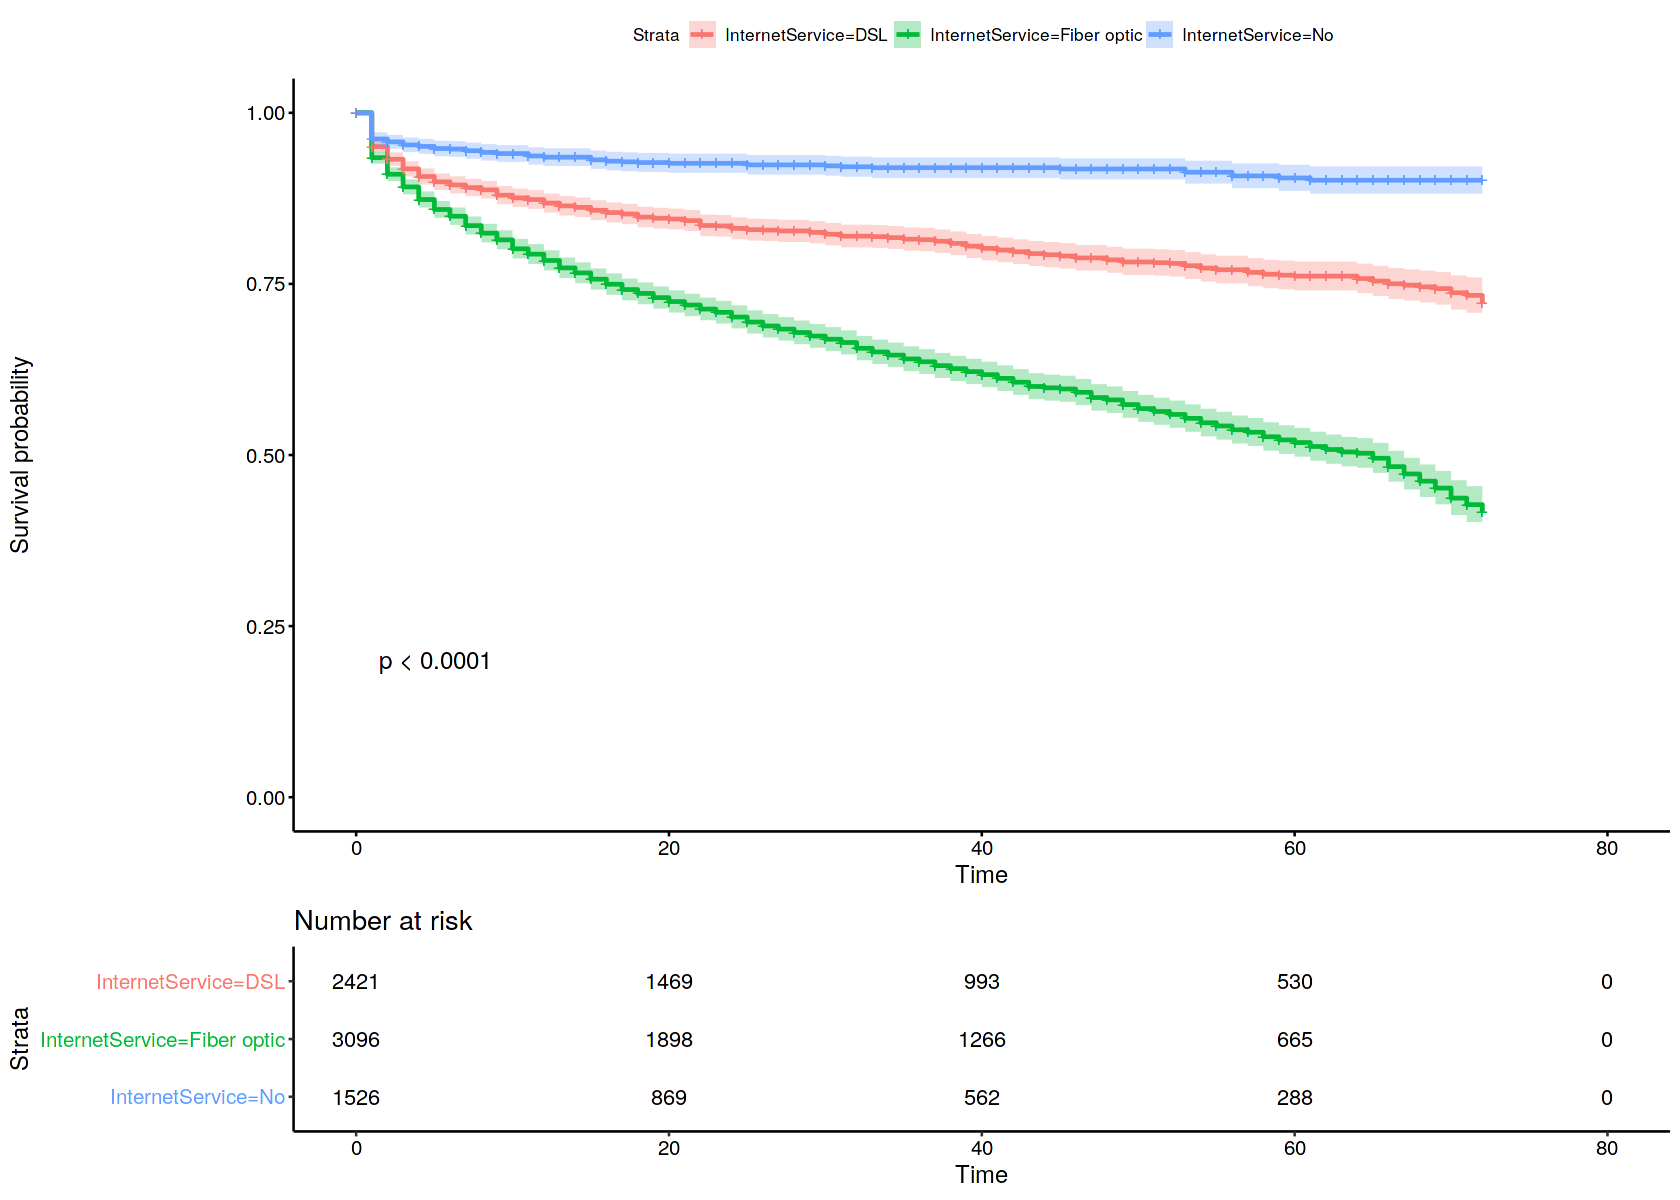

In [32]:
fit1 <- survfit(surv_object ~ InternetService, data = telco_df)
ggsurvplot(fit1, data = telco_df, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)

**OBSERVATION (perhaps the most interesting)**:


The evidence **is** sufficient to reject the null hypothesis.  
Null hypothesis: `InternetSrervice` is _not_ a factor that distinguishes the probability to churn. 

The magnitude of differences across groups were the very large for `InternetService`. Interestingly, customers without `InternetService` (in this data, meaning those only with phone service) had the largest survival rate. We had the largest churn rate for customers with Fiber Optics for the internet service. 

More similar looking plots  
plotting ref: https://rpkgs.datanovia.com/survminer/reference/arrange_ggsurvplots.html

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


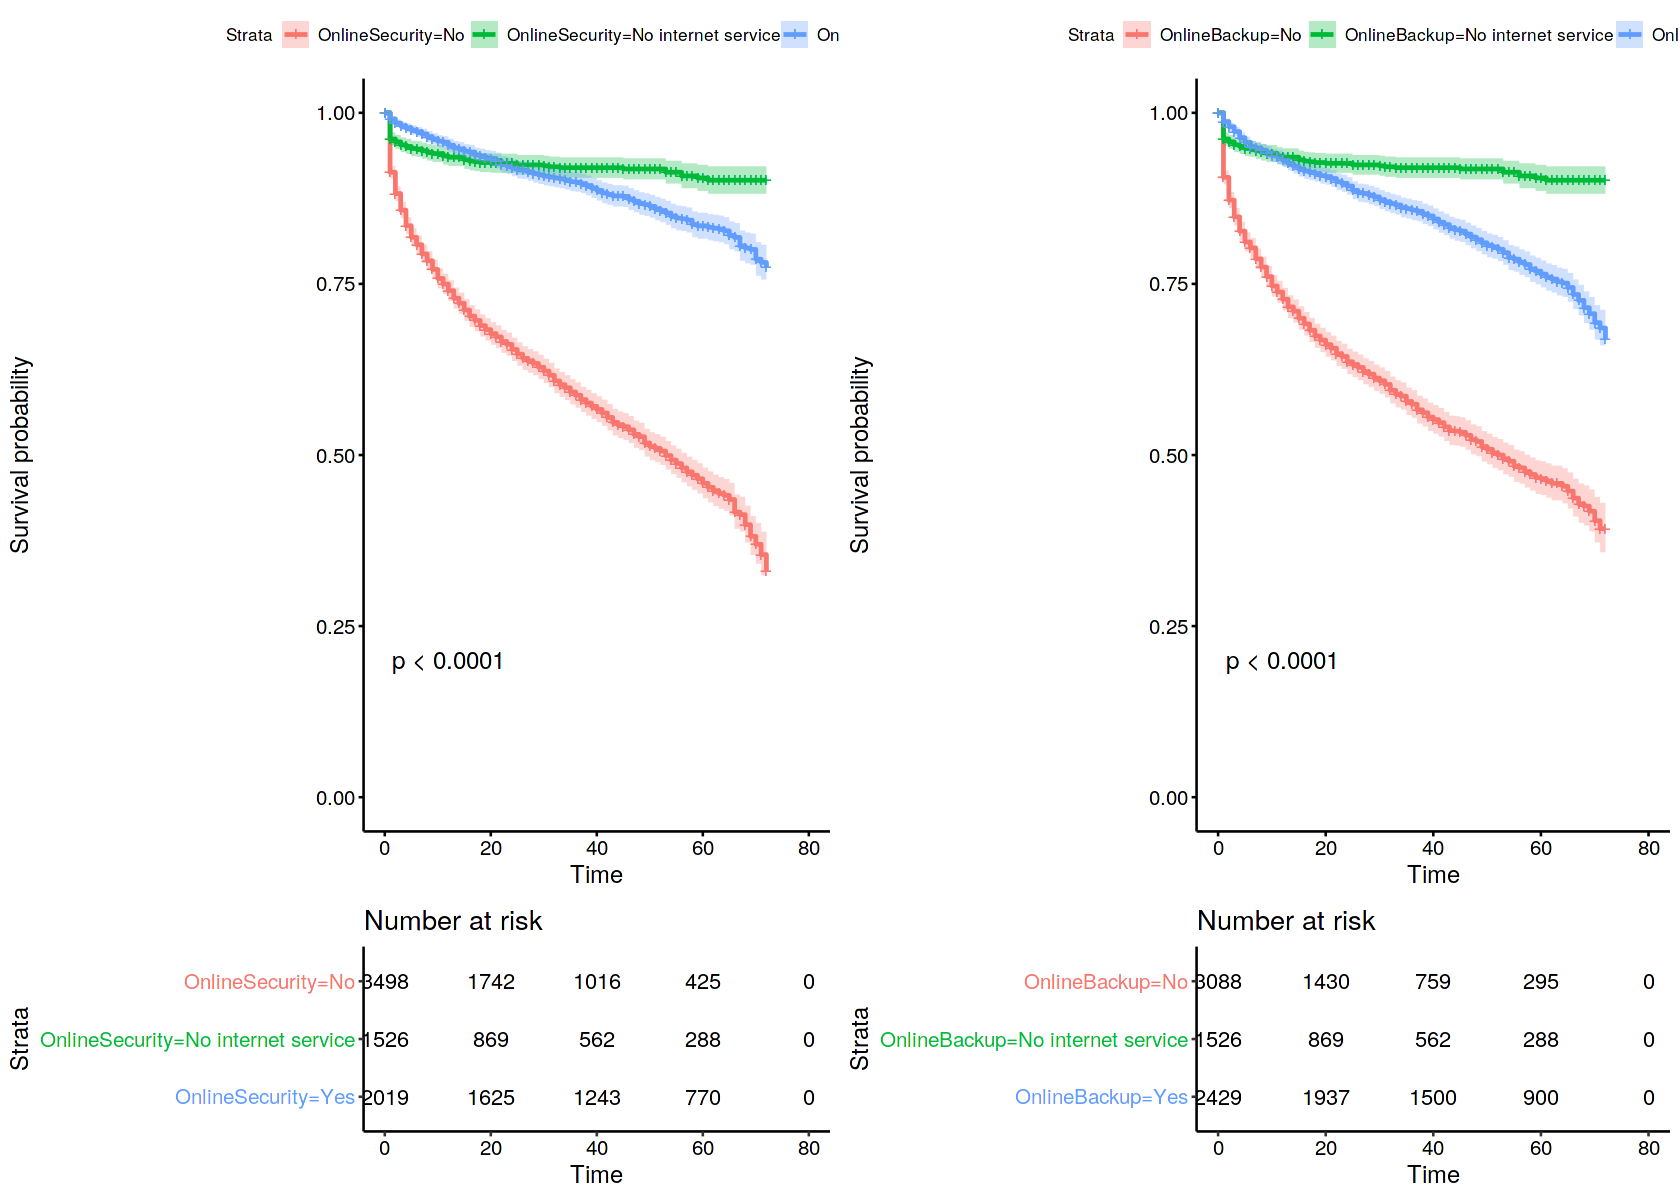

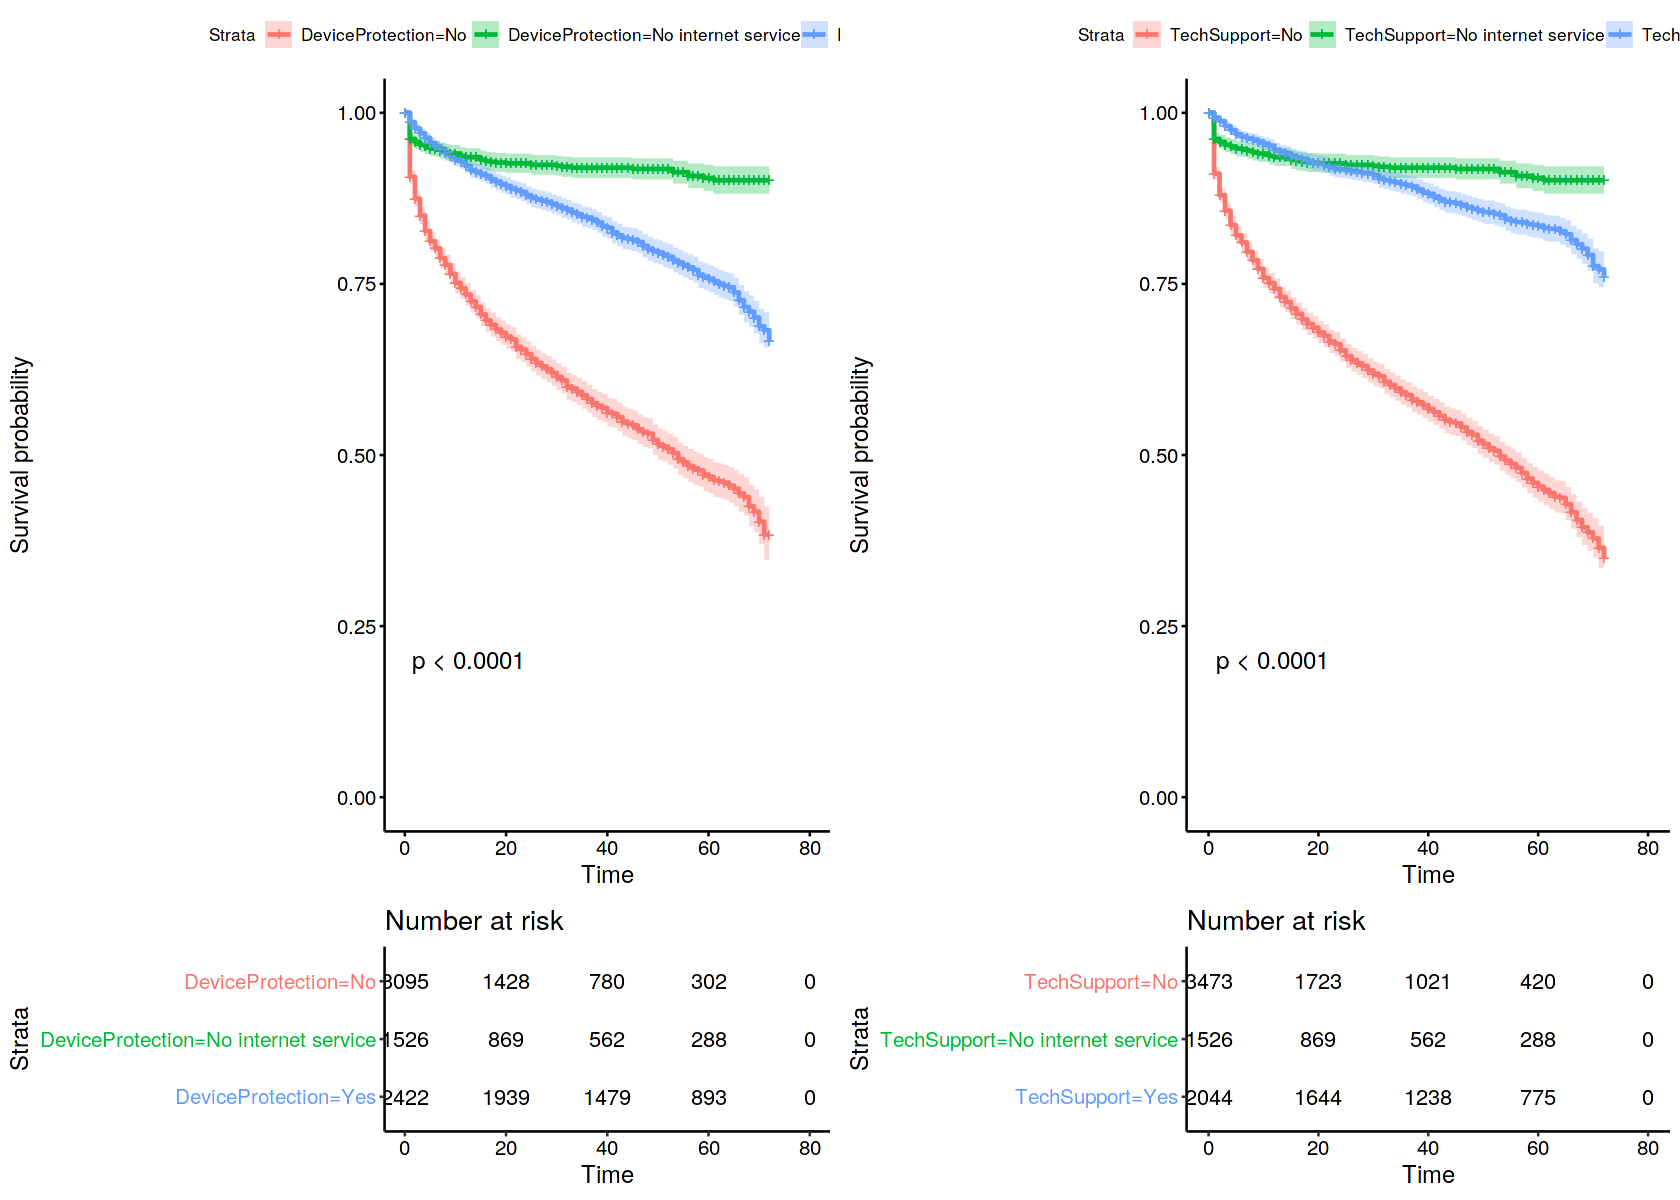

In [33]:
options(repr.plot.width = 14, repr.plot.height = 10)

splots <- list()

fit <- survfit(surv_object ~ OnlineSecurity, data = telco_df)
online_security_plt <- ggsurvplot(fit, data = telco_df, 
                                  pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)
splots[[1]] <- online_security_plt

fit <- survfit(surv_object ~ OnlineBackup, data = telco_df)
online_backup_plt <- ggsurvplot(fit, data = telco_df, 
                                pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)
splots[[2]] <- online_backup_plt

fit <- survfit(surv_object ~ DeviceProtection, data = telco_df)
device_protection_plt <- ggsurvplot(fit, data = telco_df, 
                                    pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)
splots[[3]] <- device_protection_plt

fit <- survfit(surv_object ~ TechSupport, data = telco_df)
tech_support_plt <- ggsurvplot(fit, data = telco_df, 
                               pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)
splots[[4]] <- tech_support_plt

arrange_ggsurvplots(splots, print = TRUE, ncol = 2, nrow = 1)

**OBSERVATION:**  
The above four plots look very similar. Need to check if the four services are highly correlated (e.g, the majority of customers have no `OnlineSecurity` also does not have `OnlineBackup`, `DeviceProtection`, and `TechSupport`), which sounds very likely.  

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


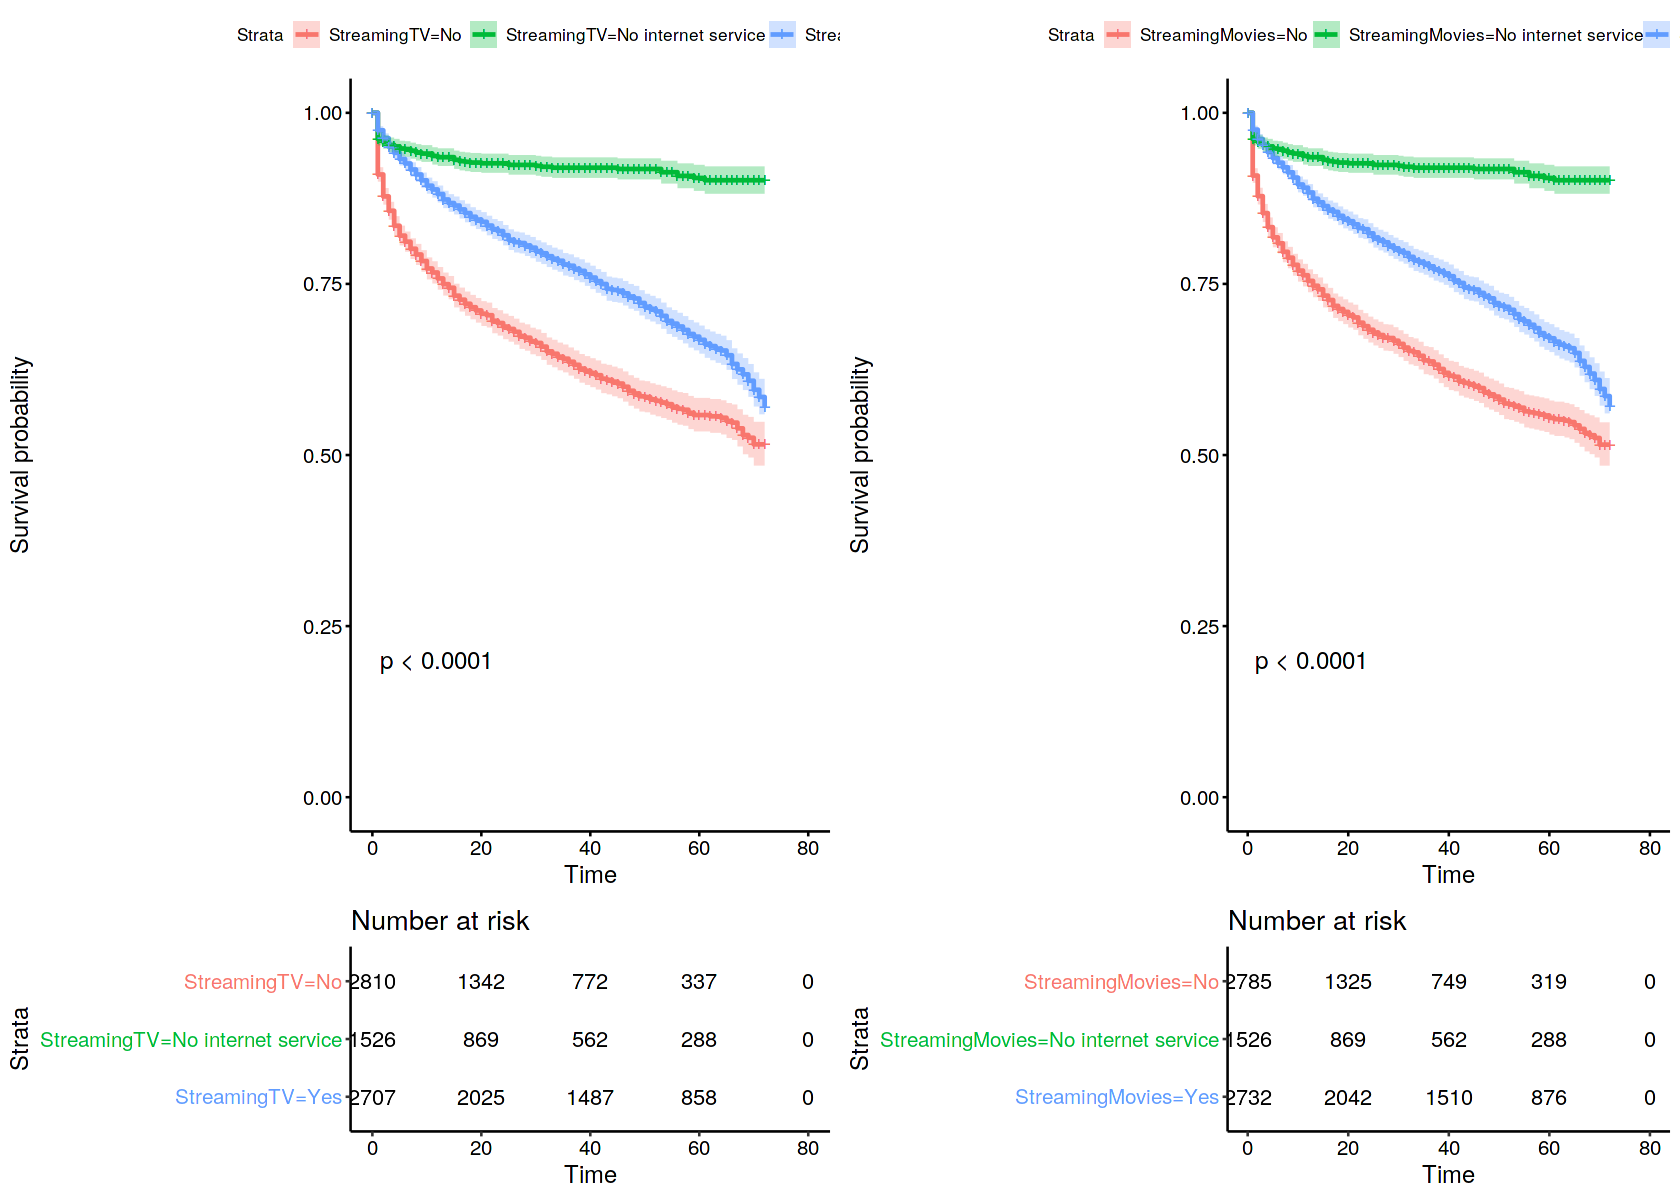

In [34]:
options(repr.plot.width = 14, repr.plot.height = 10)

splots <- list()


fit <- survfit(surv_object ~ StreamingTV, data = telco_df)
streamingTV <- ggsurvplot(fit, data = telco_df, 
                          pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)
splots[[1]] <- streamingTV

fit <- survfit(surv_object ~ StreamingMovies, data = telco_df)
streamingMovie <- ggsurvplot(fit, data = telco_df, 
                             pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)
splots[[2]] <- streamingMovie

arrange_ggsurvplots(splots, print = TRUE, ncol = 2, nrow = 1)

**OBSERVATION:**  

The above two plots look very similar. Need to check if the two services are highly correlated (e.g, the majority of customers who have `StreaminbTV` also have `StreamingMovie`), which sounds very likely.  

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


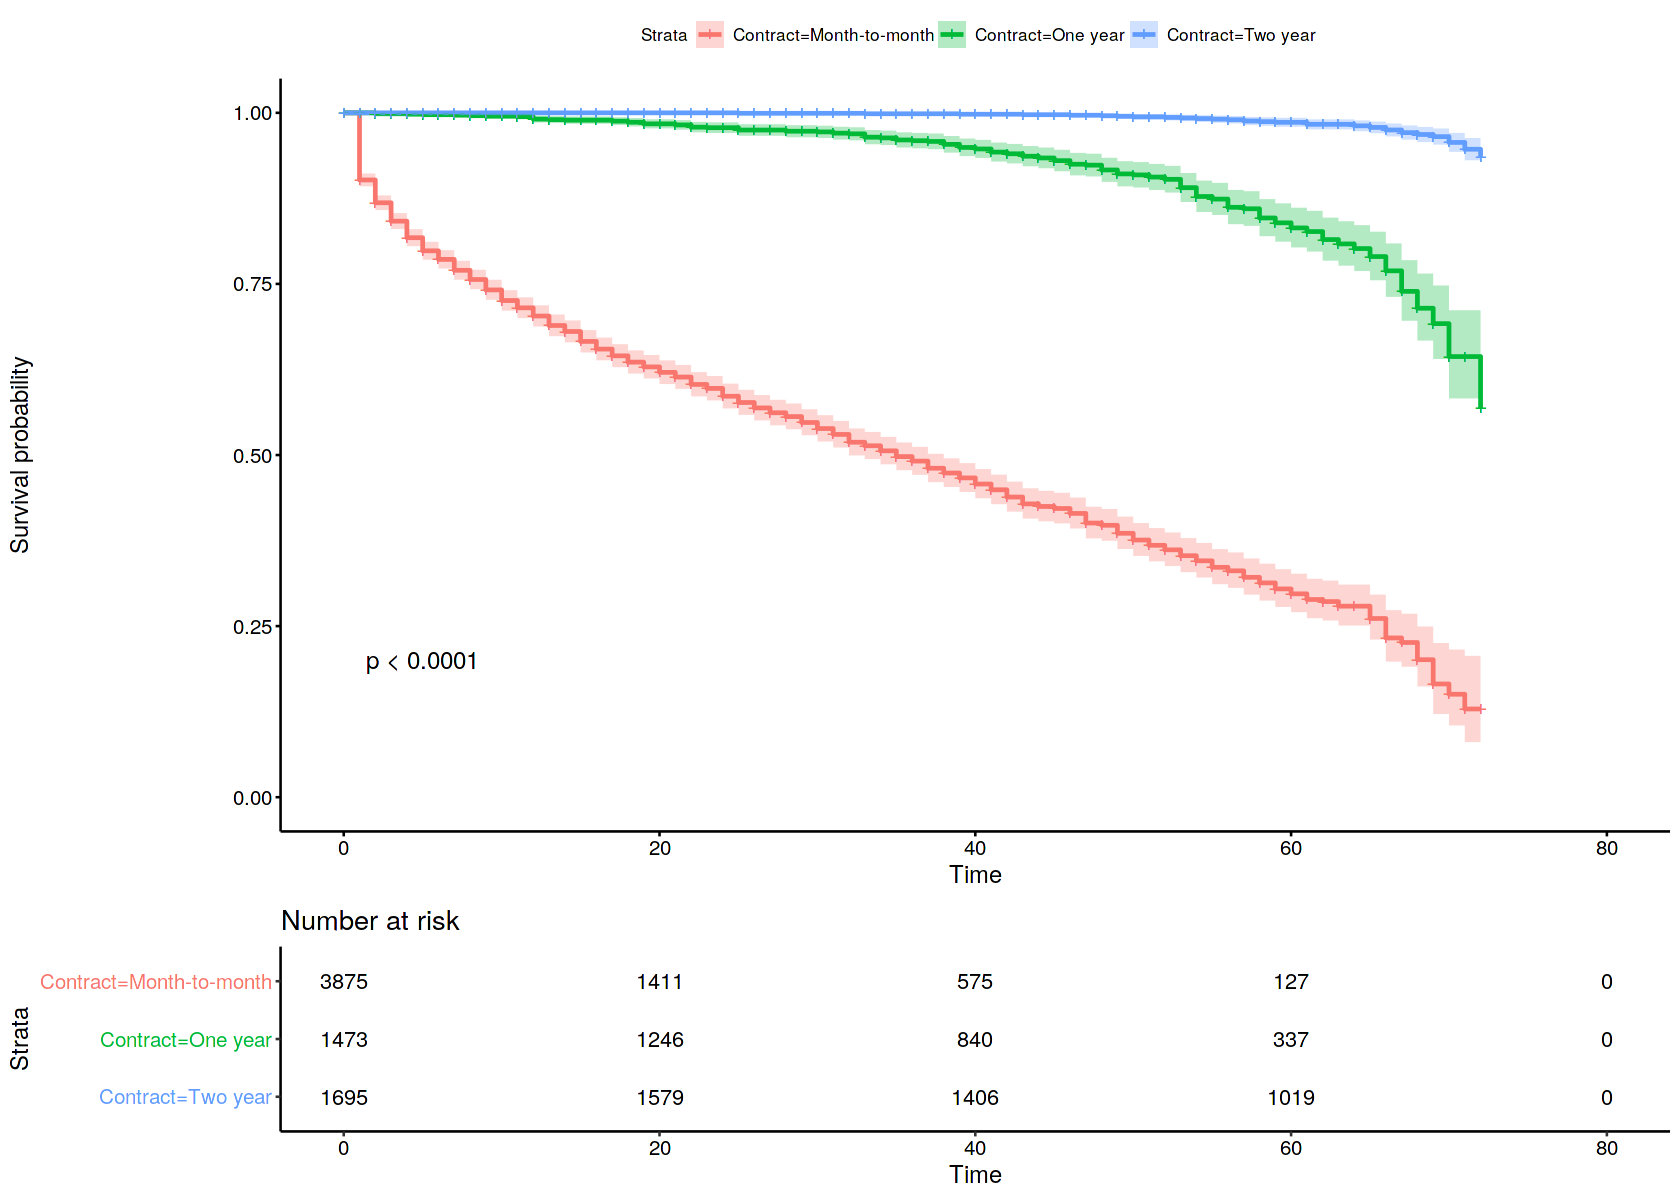

In [35]:
fit1 <- survfit(surv_object ~ Contract, data = telco_df)
ggsurvplot(fit1, data = telco_df, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)

**OBSERVATION**:


The evidence **is** sufficient to reject the null hypothesis.  
Null hypothesis: `Contract` is _not_ a factor that distinguishes the probability to churn. 

This result is hardly surprising given one year ~= 52 weeks and two years ~= 104 weeks, so do not see any significant drop before that many weeks for the `One year` and `Two year` contracts. 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


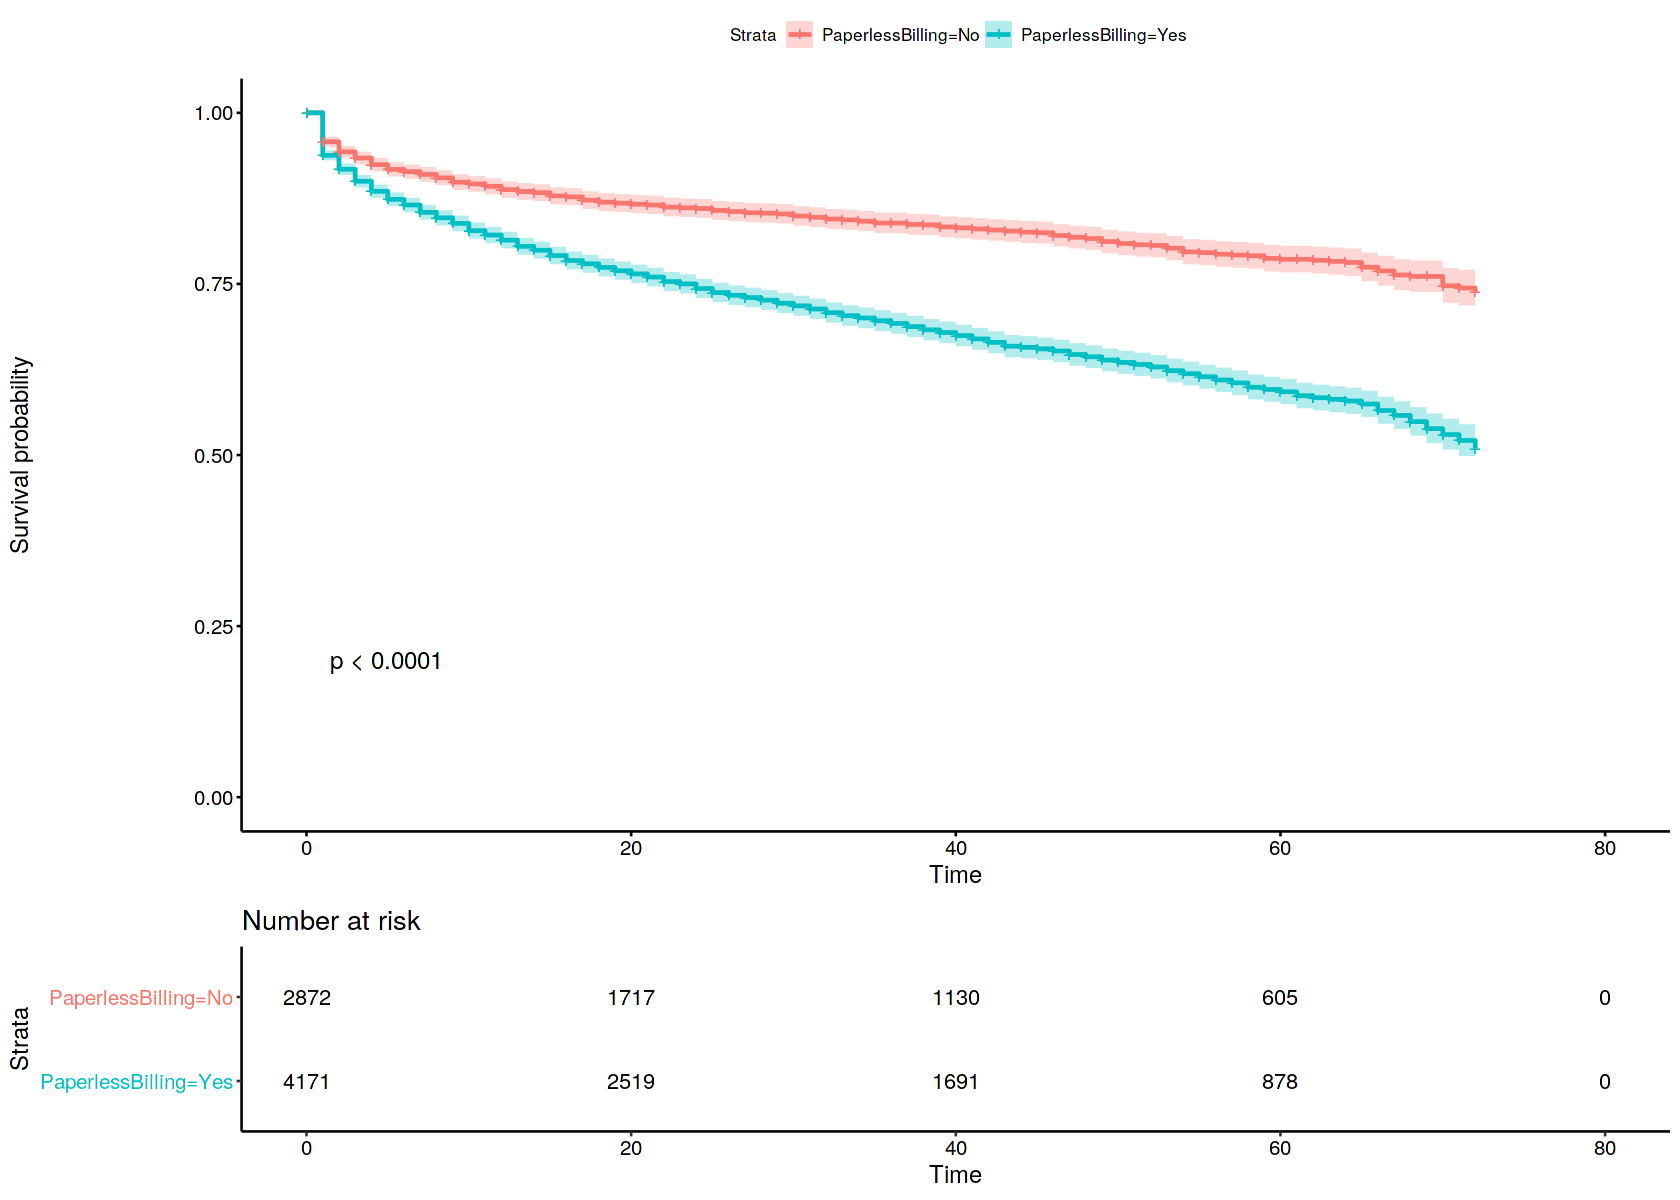

In [36]:
fit1 <- survfit(surv_object ~ PaperlessBilling, data = telco_df)
ggsurvplot(fit1, data = telco_df, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)

**OBSERVATION**:

The evidence **is** sufficient to reject the null hypothesis.  
Null hypothesis: `PaperlessBilling` is _not_ a factor that distinguishes the probability to churn. 


This was interesting as PaperlessBilling having correlation to time-to-churn was not very intuitive; customers who rolled in for PaperlessBilling was more likely to churn quicker compared to those without PaperlessBilling. 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


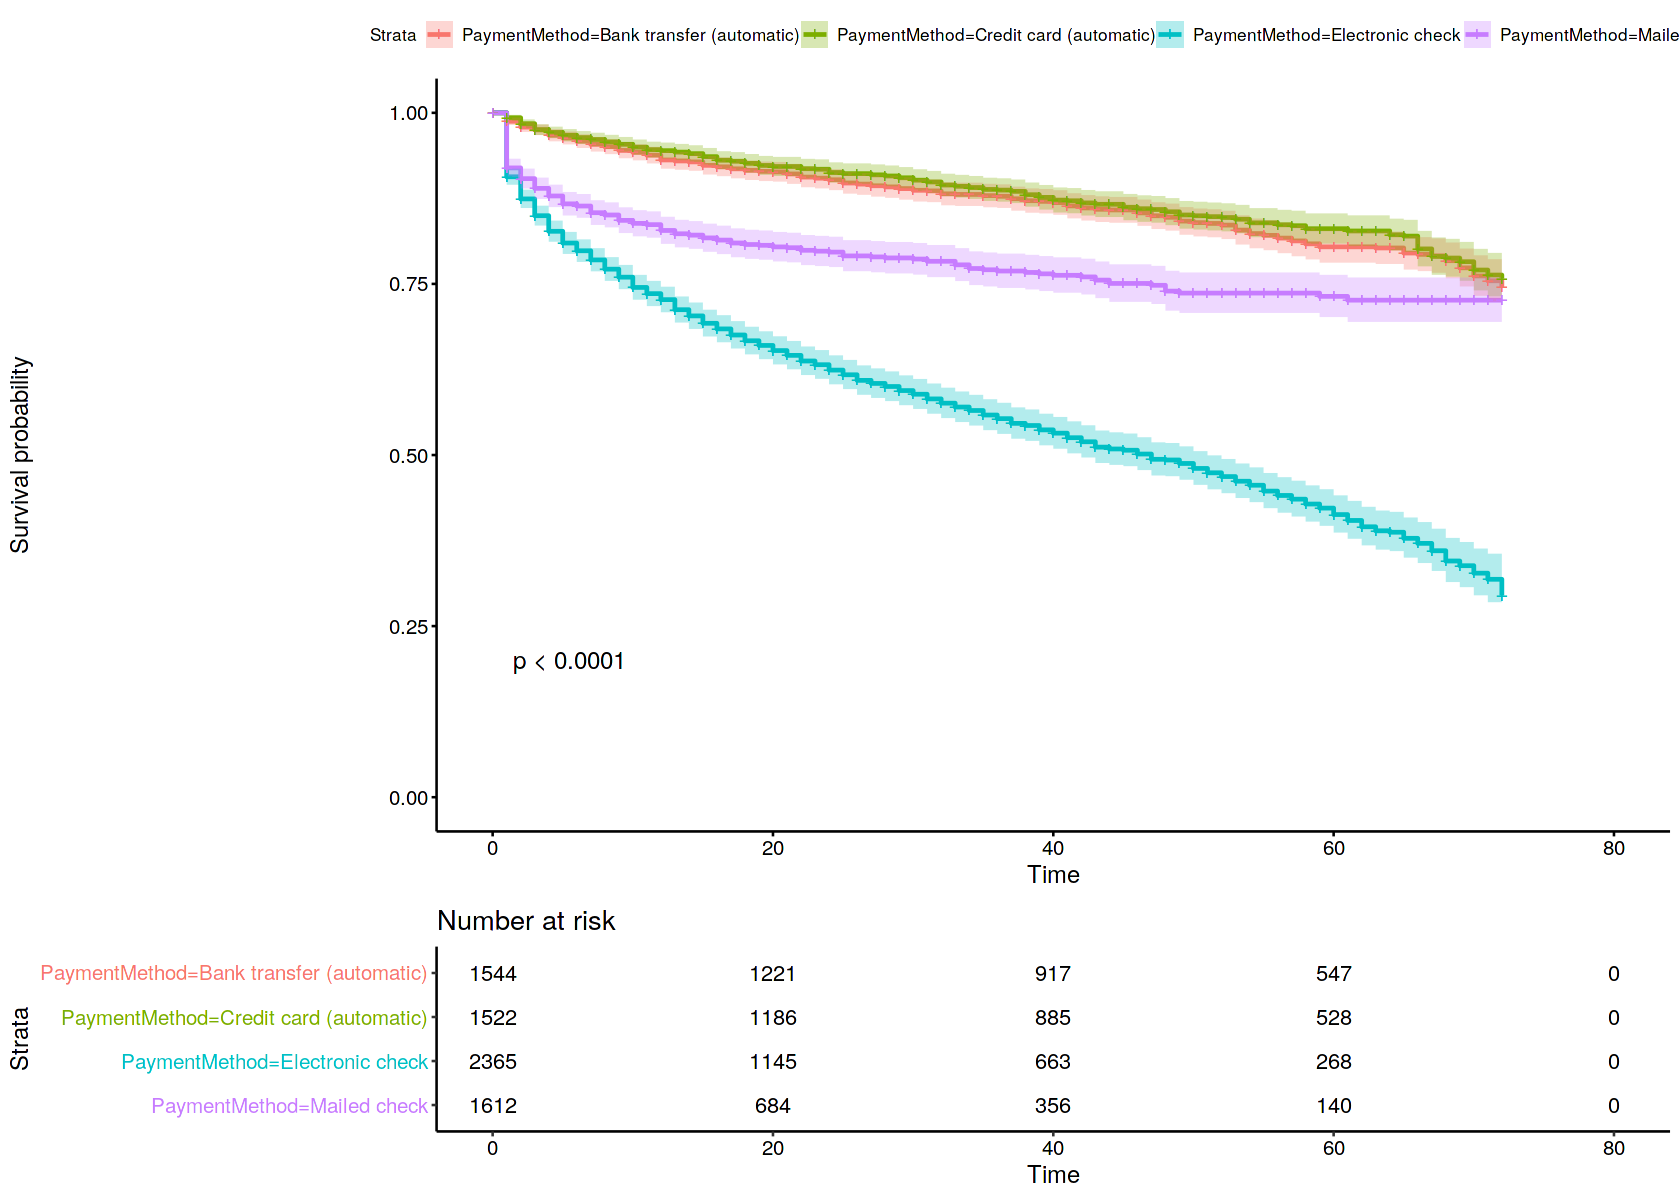

In [37]:
fit1 <- survfit(surv_object ~ PaymentMethod, data = telco_df)
ggsurvplot(fit1, data = telco_df, 
           pval = TRUE, 
           conf.int = TRUE, 
           risk.table = TRUE)

**OBSERVATION**:

The evidence **is** sufficient to reject the null hypothesis.  
Null hypothesis: `PaymentMethod` is _not_ a factor that distinguishes the probability to churn. 


Those who signed up for automatic payment services (bank transfer and credit card) were more likely to stay longer with the service.  
Those who were paying with electronic check were the most likely to leave the service, compared to other three payment methods. 

Telco could assist the customers with setting up the automated payments or have a promotion that could give enough motivation for the customers to sign up for the automated payments. 

### <font color = 'darkslateblue'> Analysis 1.2. CoxPH </font>


In [38]:
head(telco_df)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,InternetPhoneServices,total_charges_theoretical,total_charges_diff,is_churn
,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Phone: No | Internet: DSL,29.85,0.00,0
2,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Phone: Yes | Internet: DSL,1936.30,-46.80,0
3,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Phone: Yes | Internet: DSL,107.70,0.45,1
4,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Phone: No | Internet: DSL,1903.50,-62.75,0
5,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Phone: Yes | Internet: Fiber optic,141.40,10.25,1
6,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,Phone: Yes | Internet: Fiber optic,797.20,23.30,1


Since we have features that are hierarchical, we can stratify customers based on columns:  
Where, a subset of features are only applicable for a sertain subset of groups (e.g., OnlineSecurity is not an applicable column for those who does NOT have InternetService)
1. w/ only PhoneService
2. w/ only InternetService 
3. w/ both InternetService and PhoneService 

In [72]:
# there is no true or false column for internet service 
telco_df$has_InternetService <- ifelse(telco_df$InternetService != "No", "Yes", "No")
telco_df$has_InternetService <- as.factor(telco_df$has_InternetService)

telco_df %>% count(PhoneService, has_InternetService)
# observation: we have descent numbers of data points per PhoneService and has_InternetService combinations


# subset data based on internet and phone services. 
only_phone_service_df <- telco_df %>% 
    filter(PhoneService == "Yes" & has_InternetService == "No") %>% 

    dplyr::select(-c(Churn, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, TotalCharges, InternetPhoneServices, total_charges_theoretical, total_charges_diff))

only_internet_service_df <- telco_df %>% 
    filter(PhoneService == "No" & has_InternetService == "Yes") %>%
    dplyr::select(-c(Churn, MultipleLines, PhoneService, TotalCharges, InternetPhoneServices, total_charges_theoretical, total_charges_diff))

both_services_df <- telco_df %>% 
    filter(PhoneService == "Yes" & has_InternetService == "Yes") %>%
    dplyr::select(-c(Churn, TotalCharges, InternetPhoneServices, total_charges_theoretical, total_charges_diff))


PhoneService,has_InternetService,n
<fct>,<fct>,<int>
No,Yes,682
Yes,No,1526
Yes,Yes,4835


In [73]:
# only phone service 
only_phone_fit <- coxph(Surv(tenure, is_churn) ~ 
                        gender + factor(SeniorCitizen) + 
                        MultipleLines + Partner + Dependents + Contract + PaperlessBilling + PaymentMethod + MonthlyCharges, 
                        data = only_phone_service_df)
only_phone_ftest <- cox.zph(only_phone_fit)
only_phone_ftest

                        chisq df     p
gender                 0.3955  1 0.529
factor(SeniorCitizen)  0.3407  1 0.559
MultipleLines          3.9501  1 0.047
Partner                0.0411  1 0.839
Dependents             0.0212  1 0.884
Contract               3.1695  2 0.205
PaperlessBilling       1.6147  1 0.204
PaymentMethod          6.0521  3 0.109
MonthlyCharges         1.7684  1 0.184
GLOBAL                16.0418 12 0.189

In [74]:
head(only_internet_service_df)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,is_churn,has_InternetService
,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>
1,7590-VHVEG,Female,0,Yes,No,1,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,0,Yes
2,7795-CFOCW,Male,0,No,No,45,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,0,Yes
3,6713-OKOMC,Female,0,No,No,10,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,0,Yes
4,8779-QRDMV,Male,1,No,No,1,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,39.65,1,Yes
5,8665-UTDHZ,Male,0,Yes,Yes,1,DSL,No,Yes,No,No,No,No,Month-to-month,No,Electronic check,30.20,1,Yes
6,0526-SXDJP,Male,0,Yes,No,72,DSL,Yes,Yes,Yes,No,No,No,Two year,No,Bank transfer (automatic),42.10,0,Yes


In [82]:
# only internet service 
only_internet_fit <- coxph(Surv(tenure, is_churn) ~ 
                           gender + factor(SeniorCitizen) + Partner + Dependents + 
                           InternetService + OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + StreamingTV + StreamingMovies + 
                           Contract + PaperlessBilling + PaymentMethod + MonthlyCharges, 
                           data = only_internet_service_df)

only_internet_ftest <- cox.zph(only_internet_fit)
only_internet_ftest

ggforest(only_internet_fit)

                        chisq df      p
gender                 1.7939  1 0.1805
factor(SeniorCitizen)  0.9716  1 0.3243
Partner                3.6299  1 0.0567
Dependents             0.0778  1 0.7804
OnlineSecurity         0.6012  1 0.4381
OnlineBackup           1.8191  1 0.1774
DeviceProtection       6.8432  1 0.0089
TechSupport            0.1761  1 0.6748
StreamingTV            1.6810  1 0.1948
StreamingMovies        0.5804  1 0.4461
Contract               6.9067  2 0.0316
PaperlessBilling       1.9219  1 0.1657
PaymentMethod          2.3823  3 0.4969
MonthlyCharges         5.5109  1 0.0189
GLOBAL                27.8685 17 0.0465

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


ERROR: Error in `[.data.frame`(data, , var): undefined columns selected


In [81]:
# internet AND phone services
both_services_fit <- coxph(Surv(tenure, is_churn) ~ 
                           gender + factor(SeniorCitizen) + Partner + Dependents + 
                           MultipleLines + 
                           InternetService + OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + StreamingTV + StreamingMovies + 
                           Contract + PaperlessBilling + PaymentMethod + MonthlyCharges, 
                           data = both_services_df)

both_services_ftest <- cox.zph(both_services_fit)
both_services_ftest

ggforest(both_services_fit)

                        chisq df       p
gender                  0.560  1 0.45422
factor(SeniorCitizen)   0.823  1 0.36428
Partner                10.996  1 0.00091
Dependents              0.622  1 0.43032
MultipleLines          39.460  1 3.3e-10
InternetService        10.581  1 0.00114
OnlineSecurity         14.423  1 0.00015
OnlineBackup           17.452  1 2.9e-05
DeviceProtection       22.198  1 2.5e-06
TechSupport            32.509  1 1.2e-08
StreamingTV            60.667  1 6.8e-15
StreamingMovies        54.725  1 1.4e-13
Contract               66.251  2 4.1e-15
PaperlessBilling        2.201  1 0.13794
PaymentMethod          36.123  3 7.1e-08
MonthlyCharges        102.677  1 < 2e-16
GLOBAL                220.103 19 < 2e-16

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


ERROR: Error in `[.data.frame`(data, , var): undefined columns selected


---
## <font color = 'crimson'> Analysis 2 - Regression and other Modeling </font>

---

## <font color = 'crimson'> Analysis 3 - Hypothesis testing with binary labels. </font>

(TODO) Parametric and Non-parametric tests

---

Future Works: 
* Correspondence analysis
* Demonstrate Simposon's Paradox
* statistical testing 
    * parametric: 
    * non-parametric
* Outlier detection using cook'-distance 
* noramlization (preprocessing before statistical testing)  
* box-cox transformation 





**REFERENCE:**  
* survival analysis cheatsheet: https://rpkgs.datanovia.com/survminer/survminer_cheatsheet.pdf
* contingency table and independence tests: 
    * https://www.datacamp.com/community/tutorials/contingency-tables-r
    * contingency table and chi-squared test for independence: http://www.r-tutor.com/elementary-statistics/goodness-fit/chi-squared-test-independence
    * contingency table: http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/113-ca-correspondence-analysis-in-r-essentials/#:~:text=Correspondence%20analysis%20is%20a%20geometric,their%20associations%20in%20the%20table.
    * statistical testing w/ contingency table: http://www.stat.yale.edu/Courses/1997-98/101/chisq.htm#:~:text=When%20analysis%20of%20categorical%20data,basis%20of%20the%20data%20observed.
* normality test: https://www.statisticshowto.com/assumption-of-normality-test/  
* correspondence analysis 1: http://www.sthda.com/english/articles/32-r-graphics-essentials/129-visualizing-multivariate-categorical-data/  
* correspondence analysis 2: http://www.sthda.com/english/articles/31-principal-component-methods-in-r-practical-guide/113-ca-correspondence-analysis-in-r-essentials/#:~:text=Correspondence%20analysis%20is%20a%20geometric,their%20associations%20in%20the%20table.
* survival analysis: https://www.datacamp.com/community/tutorials/survival-analysis-R